# Szükséges importálások

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import subprocess
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns

from IPython.display import clear_output

#plot beállítások és paraméterek
sns.set_theme()
style = {'xtick.labelsize' : 15, 'ytick.labelsize' : 15}
plt.style.use(style)

t_s = 30
xy_s = 25
hs = 0.5
ws = 0.5

# Fontosabb függvények

In [187]:
#Analitikus megoldás tiszta normál módusra
def anal_mode1(t,n):
    x_array = np.array([i*dx for i in range(N_x)])
    
    kn = np.pi * n / L
    
    return A00 * np.sin(kn*x) * np.cos(c*kn*t)

#Analitikus megoldás két kevert normál módusra
def anal_mode2(t,n1,n2):
    x_array = np.array([i*dx for i in range(N_x)])
    
    kn1 = np.pi * n1 / L
    kn2 = np.pi * n2 / L
    
    y_array1 = A00 * np.sin(kn1*x) * np.cos(c*kn1*t)
    y_array2 = A01 * np.sin(kn2*x) * np.cos(c*kn2*t)
    
    return y_array1 + y_array2


#caption elkészítő függvény
def create_caption():
    """Globális változókat használok a függvényben"""
    
    caption = ""
    if mode == "triang":
        caption = f"L={L} m, T={T} N, rho={rho} kg/m, dt={dt} s, dx={dx} m, t_sum={t_sum} s, x00={x00} m, y00={y00} m"
    elif mode == "triangCombine":
        caption = f"L={L} m, T={T} N, rho={rho} kg/m, dt={dt} s, dx={dx} m, t_sum={t_sum} s, x00={x00} m, y00={y00} m, x01={x01} m, y01={y01} m"
    elif mode == "dirac":
        caption = f"L={L} m, T={T} N, rho={rho} kg/m, dt={dt} s, dx={dx} m, t_sum={t_sum} s, x00={x00} m, y00={y00} m"
    elif mode == "mode1":
        caption = f"L={L} m, T={T} N, rho={rho} kg/m, dt={dt} s, dx={dx} m, t_sum={t_sum} s,A00={A00} m, NoM1={n00}"
    elif mode == "mode2":
        caption = f"L={L} m, T={T} N, rho={rho} kg/m, dt={dt} s, dx={dx} m, t_sum={t_sum} s,A00={A00} m, NoM1={n00}, A01={A01} m, NoM2={n01}"
    else:
        print("Nem jó a mode paraméter! Válassz újat!")
        
    return caption
    
#animációhoz szükséges képek elkészítése
def hur_animation_imgs(file,save_ani):
    """Elkészíti az animáció képeit a file-ban található adatokból és elmenti a save_ani helyen."""
    
    #x adatpontok és t időpillanatok megadása
    x = np.linspace(0,L,N_x)
    t = np.linspace(0,t_sum,N_t)

    #Ábra határok
    yMaxAbs = 0
    if mode == "triang":
        yMaxAbs = abs(y00)
    elif mode == "triangCombine":
        yMaxAbs = max(abs(y00),abs(y01))
    elif mode == "dirac":
        yMaxAbs = abs(y00)
    elif mode == "mode1":
        yMaxAbs = abs(A00)
    elif mode == "mode2":
        yMaxAbs = abs(A01+A00)
    else:
        yMaxAbs = 1

    xmin = -0.05 * L
    xmax = 1.05 * L
    ymin = -1.05 * yMaxAbs
    ymax = 1.05 * yMaxAbs

    #style megadása
    dic = {"xtick.labelsize" : tick_s, "ytick.labelsize" : tick_s}
    plt.style.use(dic)

    #ábra inicializálása
    fig = plt.figure(figsize=(20,17))
    fig.suptitle("Húr animáció",fontsize=45)
    fig.text(0.5, 0.05, caption, ha='center', fontsize=25)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax.set_xlabel("X [m]",fontsize=30)
    ax.set_ylabel("Y [m]",fontsize=30)
    ax.grid(b=True)

    hurfig, = ax.plot([], [], 'o-', markersize=1, color="red")
    time_template = 'time = %.4f s'
    time_text = ax.text(0.0, 0.9, '', transform=ax.transAxes,fontsize=24)

    #file beolvasás és képek elkészítése
    f = open(file,"r")
    yi = None

    for i in range(N_t):
        try:
            yi = np.array(f.readline().strip().split('\t'),dtype=float)
        except:
            print("End of File.")
            break

        hurfig.set_data(x,yi)

        time_text.set_text(time_template % (t[i]))
        plt.savefig(f"{save_ani}/%4.4d.jpg"% (i))

        if i % (N_t // 20) == 0:
            szazalek = t[i] / t_sum * 100
            print(f"A folyamat állapota {szazalek} %.")

    f.close()

#animációs függvény (képek kellenek hozzá)
def save_video(img_name,video_name,speed=10):
    img0=cv2.imread(glob.glob("{}/0000.jpg".format(img_name))[0])
    frameSize = (img0.shape[1], img0.shape[0])
    out = cv2.VideoWriter('{}.avi'.format(video_name),cv2.VideoWriter_fourcc(*'DIVX'), speed, frameSize)
    
    for filename in sorted(glob.glob('{}/*.jpg'.format(img_name)), key=os.path.getmtime):
        img = cv2.imread(filename)
        out.write(img)
    out.release()

In [3]:
tick_s = 25 #xtick ytick size
st_s = 30 #suptitle size
t_s = 30 #axis title size
xy_s = 25 #xy axis label size
hs = 1 #hspace
ws = 1 #wspace

ani_figsize = (20,17)
ani_st_s = 45

# Feladat 1

**Készítsd el és teszteld a programot, ami megoldja a hullámegyenletet. készíts ábrát és animációt a húr mozgásáról.**

Kétszer futtatom a kódot triang módban, mindkettőből animációt készítek és hármas ábrákat (y-x adott időpontokban, y-t és v-t).

### Első triang mód (c<c')

In [198]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.0001
dx = 0.01
t_sum = 1
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "triang"
save = "./data/f1/triang.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.0001', '0.01', '1.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'triang', './data/f1/triang.data'], returncode=0)

A folyamat állapota 0.0 %.
A folyamat állapota 5.0 %.
A folyamat állapota 10.0 %.
A folyamat állapota 15.0 %.
A folyamat állapota 20.0 %.
A folyamat állapota 25.0 %.
A folyamat állapota 30.0 %.
A folyamat állapota 35.0 %.
A folyamat állapota 40.0 %.
A folyamat állapota 45.0 %.
A folyamat állapota 50.0 %.
A folyamat állapota 55.00000000000001 %.
A folyamat állapota 60.0 %.
A folyamat állapota 65.0 %.
A folyamat állapota 70.0 %.
A folyamat állapota 75.0 %.
A folyamat állapota 80.0 %.
A folyamat állapota 85.00000000000001 %.
A folyamat állapota 90.0 %.
A folyamat állapota 95.0 %.
A folyamat állapota 100.0 %.


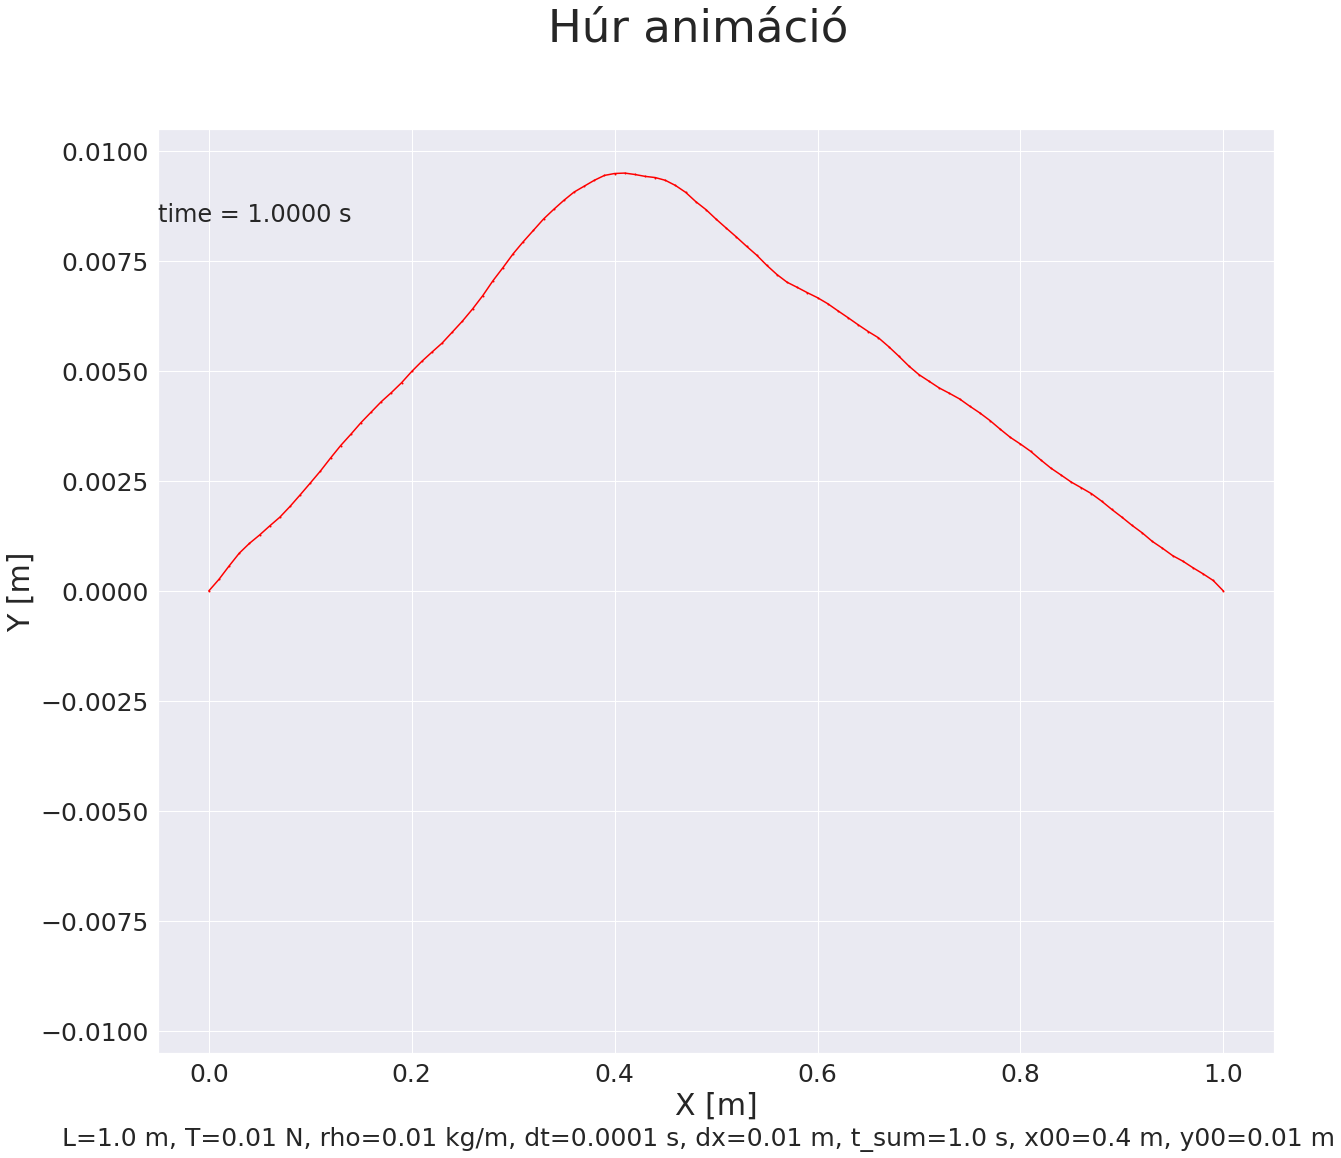

In [200]:
# ANIMÁCIÓ ELKÉSZÍTÉSE

save_ani = "./imgs/f1/animation_imgs1"

hur_animation_imgs(save,save_ani)
save_video(save_ani,"./animations/animation_f1_triang1",speed=200)

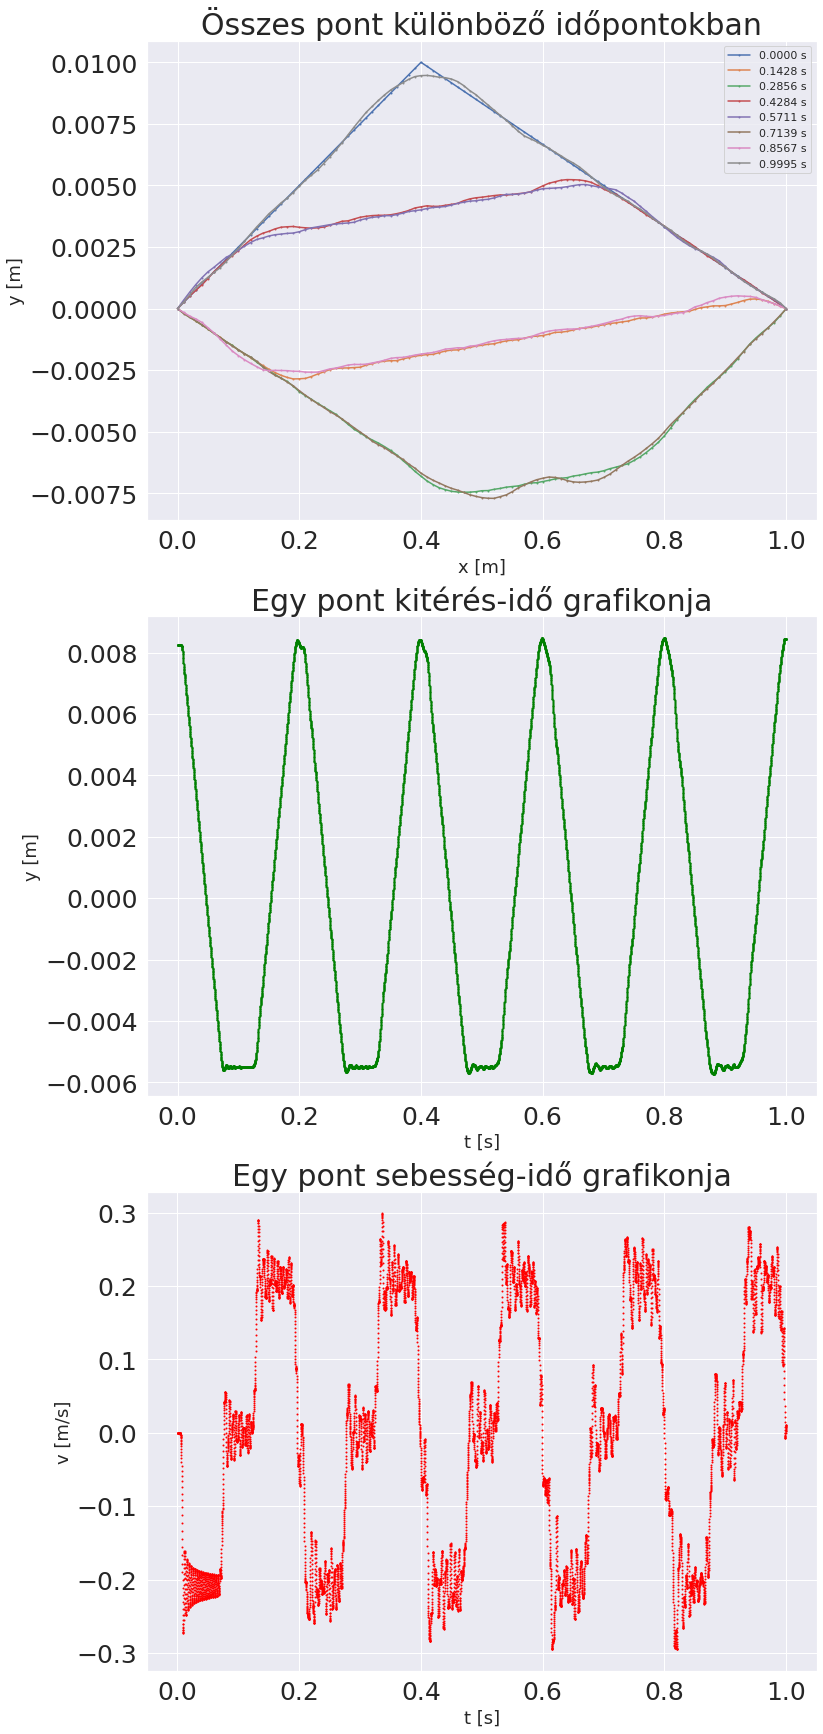

In [201]:
fig, ax = plt.subplots(3,1,figsize=(12,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    ax[1].plot(i*dt,yi[N_x//3],'o',markersize=1,color="green")
    if yi_ is not None:
        ax[2].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=1,color="red")
    yi_ = yi[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0].plot(x,yi,'-o',markersize=1,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0].legend()
ax[0].set_xlabel("x [m]",fontsize=xy_s)
ax[0].set_ylabel("y [m]",fontsize=xy_s)
ax[0].set_title("Összes pont különböző időpontokban",fontsize=t_s)
ax[1].set_xlabel("t [s]",fontsize=xy_s)
ax[1].set_ylabel("y [m]",fontsize=xy_s)
ax[1].set_title("Egy pont kitérés-idő grafikonja",fontsize=t_s)
ax[2].set_xlabel("t [s]",fontsize=xy_s)
ax[2].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2].set_title("Egy pont sebesség-idő grafikonja",fontsize=t_s)

plt.savefig("imgs/f1/triang1.jpg")

### Második triang mód (c=c')

In [194]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.001
dx = 0.001
t_sum = 5
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "triang"
save = "./data/f1/triang.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.001', '0.001', '5.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'triang', './data/f1/triang.data'], returncode=0)

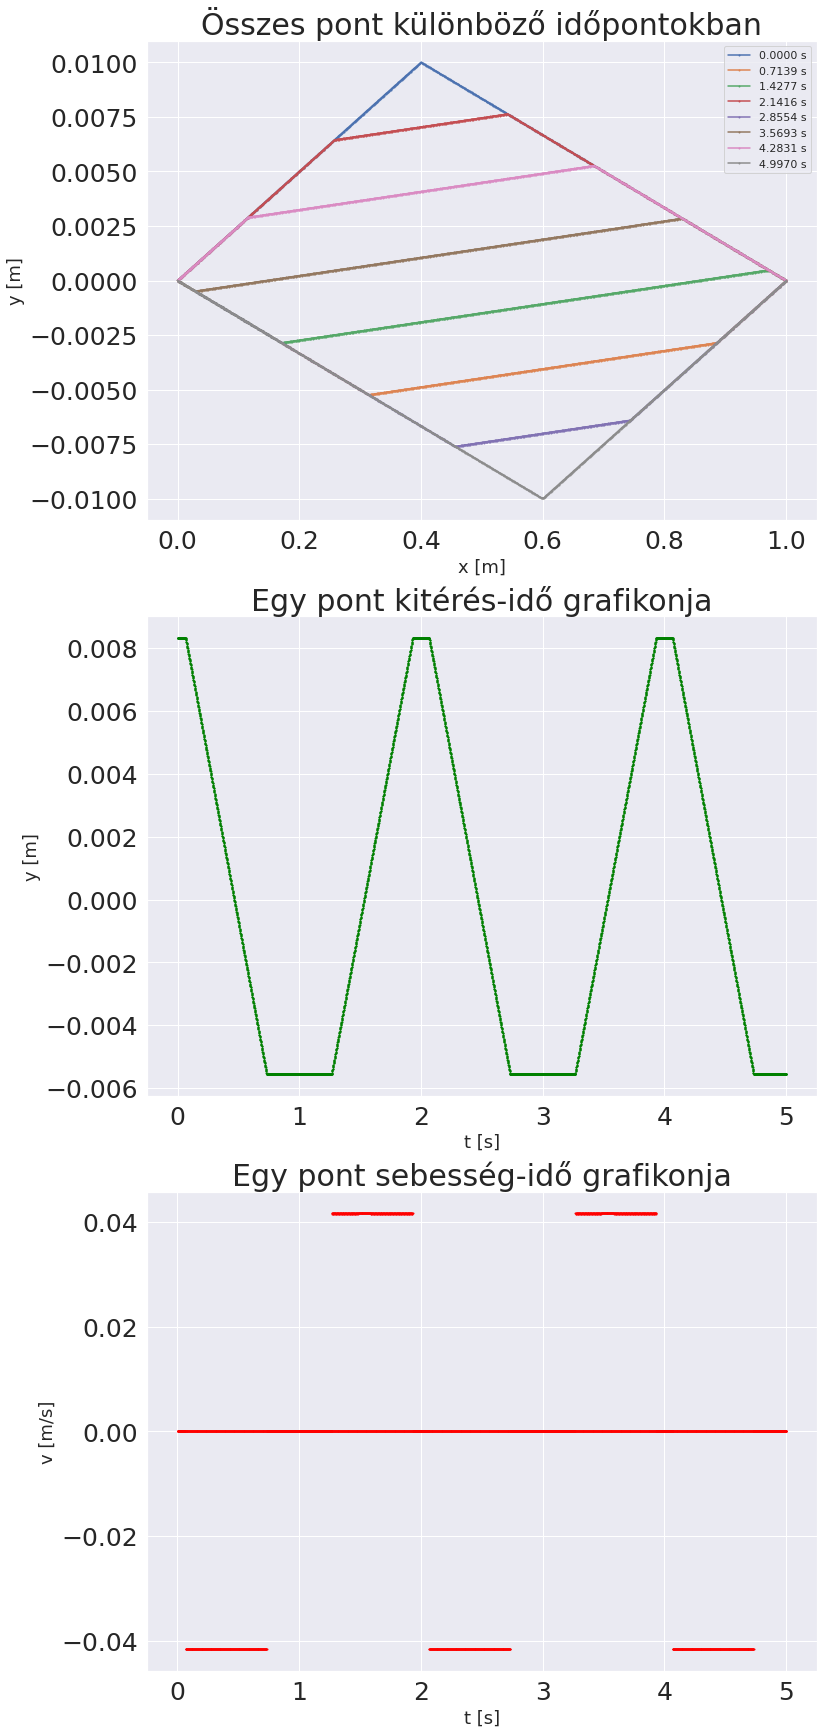

In [197]:
fig, ax = plt.subplots(3,1,figsize=(12,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    ax[1].plot(i*dt,yi[N_x//3],'o',markersize=1,color="green")
    if yi_ is not None:
        ax[2].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=1,color="red")
    yi_ = yi[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0].plot(x,yi,'-o',markersize=1,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0].legend()
ax[0].set_xlabel("x [m]",fontsize=xy_s)
ax[0].set_ylabel("y [m]",fontsize=xy_s)
ax[0].set_title("Összes pont különböző időpontokban",fontsize=t_s)
ax[1].set_xlabel("t [s]",fontsize=xy_s)
ax[1].set_ylabel("y [m]",fontsize=xy_s)
ax[1].set_title("Egy pont kitérés-idő grafikonja",fontsize=t_s)
ax[2].set_xlabel("t [s]",fontsize=xy_s)
ax[2].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2].set_title("Egy pont sebesség-idő grafikonja",fontsize=t_s)

plt.savefig("imgs/f1/triang2.jpg")

In [196]:
# ANIMÁCIÓ ELKÉSZÍTÉSE

save_ani = "./imgs/f1/animation_imgs2"

hur_animation_imgs(save,save_ani)
save_video(save_ani,"./animations/animation_f1_triang2",speed=120)

# Feladat 2 és 4

**2: Vesd egybe a megoldásod az analitikus megoldással (Fourer-sorral), ha normál módusnak megfelelő kezdeti feltételt adsz meg.**

**4: Delta x és delta t változtatásával térképezd fel a rendszer stabilitását (c<=c')**

Mindent azonosnak választok az egyes feladathoz képest, csak a kezdeti feltételt változtatom. Készítek szimulációt, illetve hatos ábrát, két oszlopban, az egyes feladathoz hasonlóan annyi különbséggel, hogy készül egy második oszlop is, mely az analitikus megoldásokat fogja tartalmazni.

5 különböző c' értékkel futtatom a szimulációt és ábrázolom őket (mindegyiket maximálisan addig, amíg az amplitúdó nem lesz az eredeti tízszerese

In [216]:
tick_s = 25 #xtick ytick size
st_s = 30 #suptitle size
t_s = 30 #axis title size
xy_s = 18 #xy axis label size
hs = 1 #hspace
ws = 1 #wspace
ms = 3 #markersize

style = {'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.style.use(style)

## 1 (c<c')

In [5]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.0001
dx = 0.01
t_sum = 1
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.0001', '0.01', '1.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'mode1', './data/f2/mode1.data'], returncode=0)

c = 1.0000 m/s, c' = 10.0000 m/s


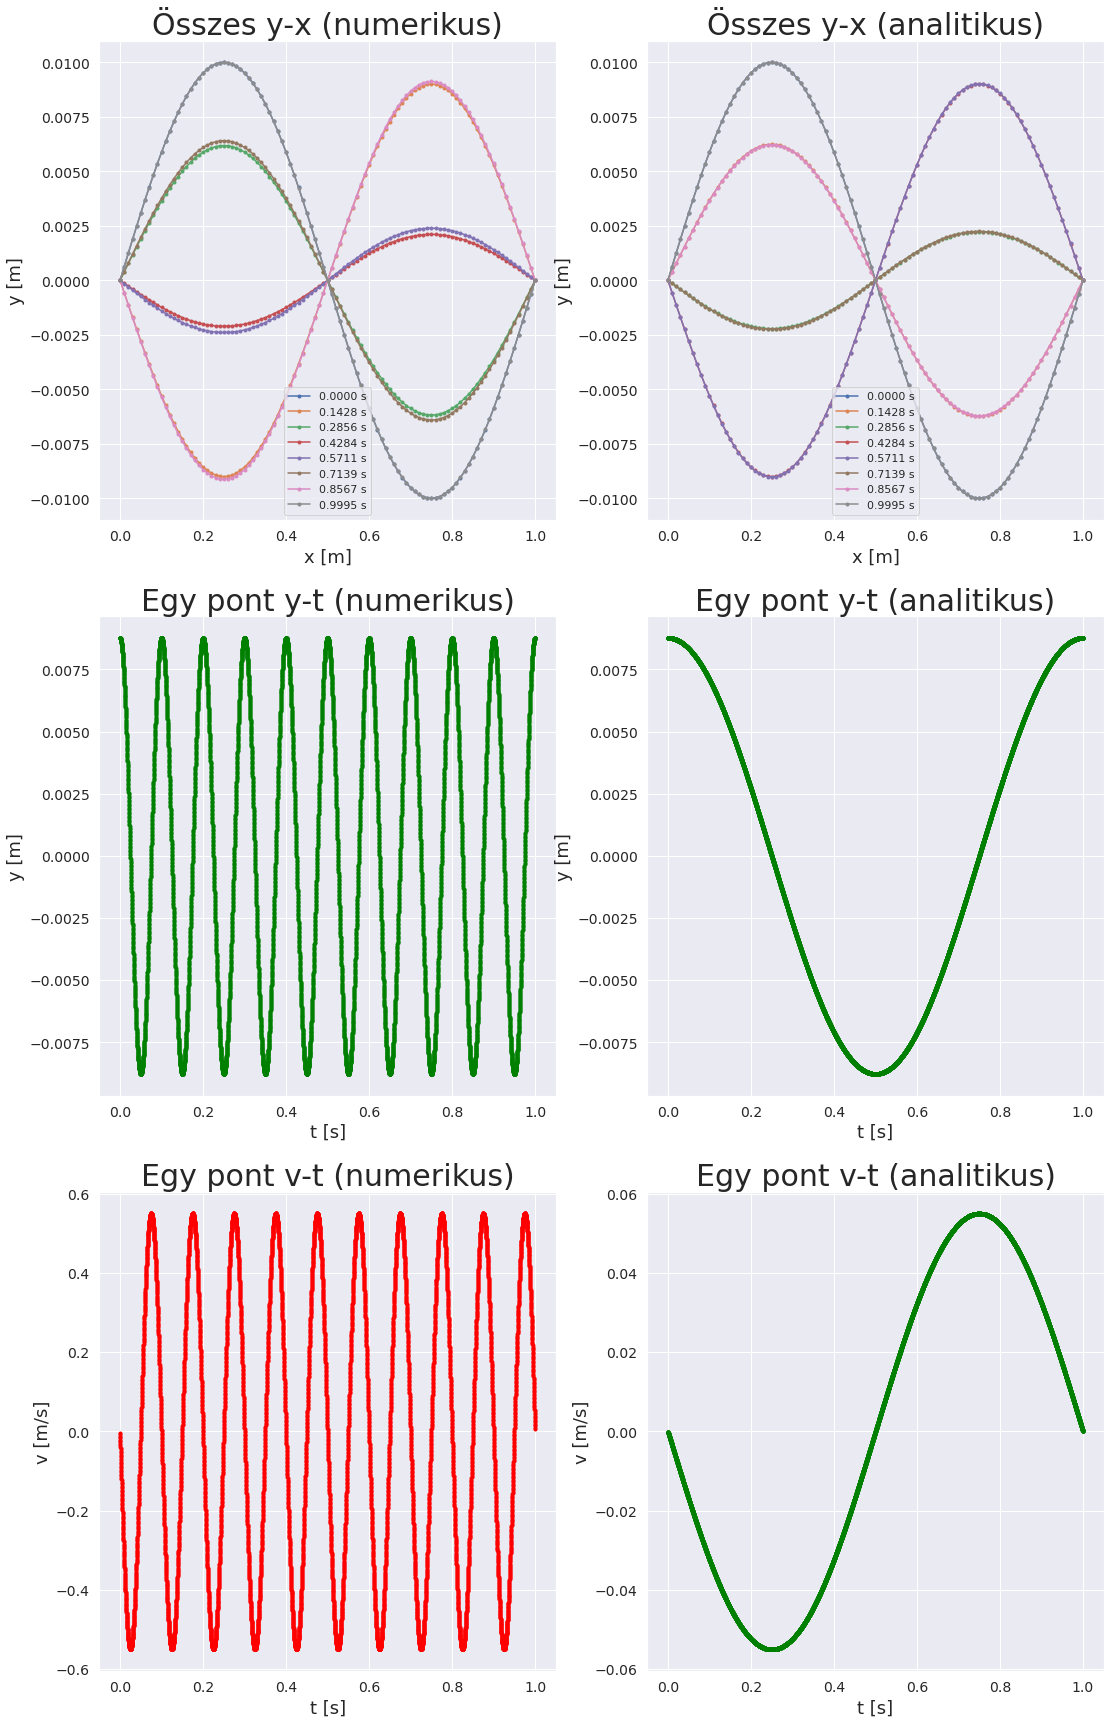

In [6]:
fig, ax = plt.subplots(3,2,figsize=(18,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
y_anal_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    yia = anal_mode1(i*dt,n00)
    ax[1][0].plot(i*dt,yi[N_x//3],'o',markersize=ms,color="green")
    ax[1][1].plot(i*dt,yia[N_x//3],'o',markersize=ms,color="green")
    if yi_ is not None:
        ax[2][0].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=ms,color="red")
        ax[2][1].plot(i*dt,(yia[N_x//3]-y_anal_)/dt,'o',markersize=ms,color="green")
    yi_ = yi[N_x//3]
    y_anal_ = yia[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0][0].plot(x,yi,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
        ax[0][1].plot(x,yia,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0][0].legend()
ax[0][0].set_xlabel("x [m]",fontsize=xy_s)
ax[0][0].set_ylabel("y [m]",fontsize=xy_s)
ax[0][0].set_title("Összes y-x (numerikus)",fontsize=t_s)
ax[1][0].set_xlabel("t [s]",fontsize=xy_s)
ax[1][0].set_ylabel("y [m]",fontsize=xy_s)
ax[1][0].set_title("Egy pont y-t (numerikus)",fontsize=t_s)
ax[2][0].set_xlabel("t [s]",fontsize=xy_s)
ax[2][0].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][0].set_title("Egy pont v-t (numerikus)",fontsize=t_s)
ax[0][1].legend()
ax[0][1].set_xlabel("x [m]",fontsize=xy_s)
ax[0][1].set_ylabel("y [m]",fontsize=xy_s)
ax[0][1].set_title("Összes y-x (analitikus)",fontsize=t_s)
ax[1][1].set_xlabel("t [s]",fontsize=xy_s)
ax[1][1].set_ylabel("y [m]",fontsize=xy_s)
ax[1][1].set_title("Egy pont y-t (analitikus)",fontsize=t_s)
ax[2][1].set_xlabel("t [s]",fontsize=xy_s)
ax[2][1].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][1].set_title("Egy pont v-t (analitikus)",fontsize=t_s)

plt.savefig("imgs/f2/mode1_1.jpg")

print("c = %4.4f m/s, c' = %4.4f m/s" %(c,c_))

## 2 (c<c')

In [7]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.001
dx = 0.01
t_sum = 1
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.001', '0.01', '1.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'mode1', './data/f2/mode1.data'], returncode=0)

c = 1.0000 m/s, c' = 3.1623 m/s


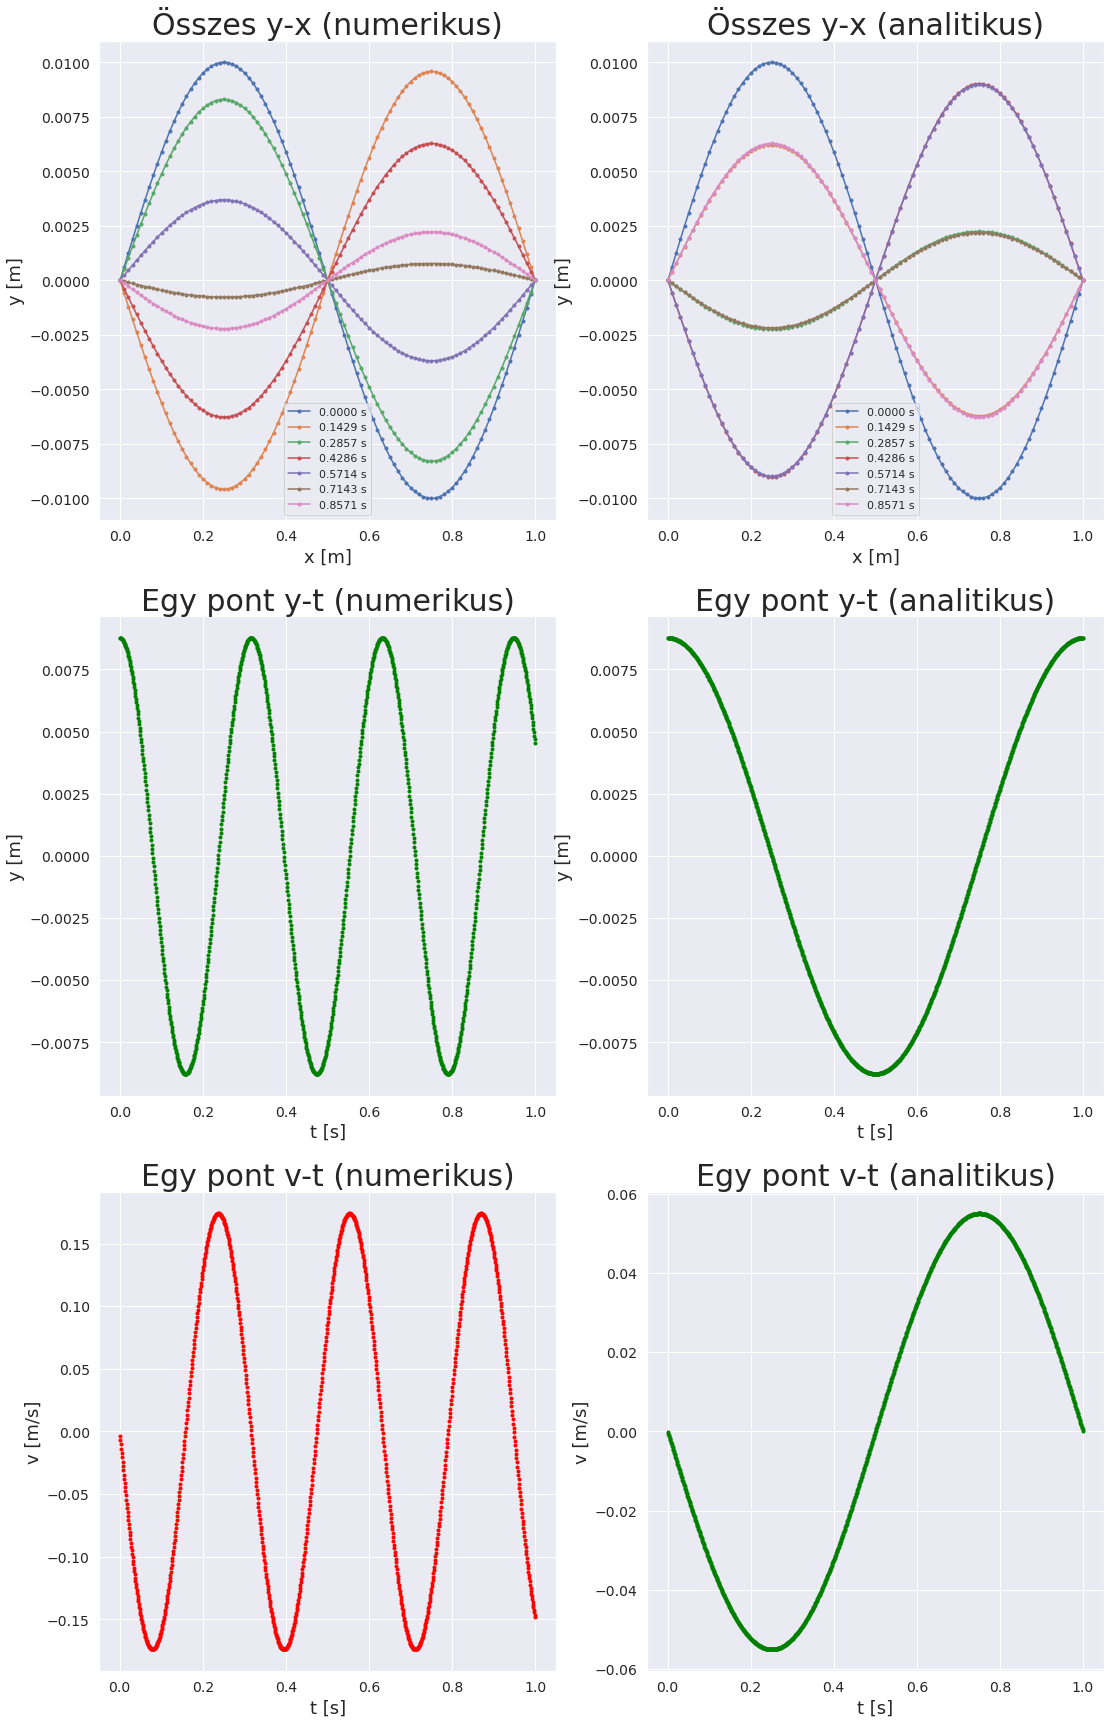

In [8]:
fig, ax = plt.subplots(3,2,figsize=(18,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
y_anal_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    yia = anal_mode1(i*dt,n00)
    ax[1][0].plot(i*dt,yi[N_x//3],'o',markersize=ms,color="green")
    ax[1][1].plot(i*dt,yia[N_x//3],'o',markersize=ms,color="green")
    if yi_ is not None:
        ax[2][0].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=ms,color="red")
        ax[2][1].plot(i*dt,(yia[N_x//3]-y_anal_)/dt,'o',markersize=ms,color="green")
    yi_ = yi[N_x//3]
    y_anal_ = yia[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0][0].plot(x,yi,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
        ax[0][1].plot(x,yia,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0][0].legend()
ax[0][0].set_xlabel("x [m]",fontsize=xy_s)
ax[0][0].set_ylabel("y [m]",fontsize=xy_s)
ax[0][0].set_title("Összes y-x (numerikus)",fontsize=t_s)
ax[1][0].set_xlabel("t [s]",fontsize=xy_s)
ax[1][0].set_ylabel("y [m]",fontsize=xy_s)
ax[1][0].set_title("Egy pont y-t (numerikus)",fontsize=t_s)
ax[2][0].set_xlabel("t [s]",fontsize=xy_s)
ax[2][0].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][0].set_title("Egy pont v-t (numerikus)",fontsize=t_s)
ax[0][1].legend()
ax[0][1].set_xlabel("x [m]",fontsize=xy_s)
ax[0][1].set_ylabel("y [m]",fontsize=xy_s)
ax[0][1].set_title("Összes y-x (analitikus)",fontsize=t_s)
ax[1][1].set_xlabel("t [s]",fontsize=xy_s)
ax[1][1].set_ylabel("y [m]",fontsize=xy_s)
ax[1][1].set_title("Egy pont y-t (analitikus)",fontsize=t_s)
ax[2][1].set_xlabel("t [s]",fontsize=xy_s)
ax[2][1].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][1].set_title("Egy pont v-t (analitikus)",fontsize=t_s)

plt.savefig("imgs/f2/mode1_2.jpg")

print("c = %4.4f m/s, c' = %4.4f m/s" %(c,c_))

## 3 (c=c')

In [214]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.01
dx = 0.01
t_sum = 5
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.01', '0.01', '5.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'mode1', './data/f2/mode1.data'], returncode=0)

idáig eljut
c = 1.0000 m/s, c' = 1.0000 m/s


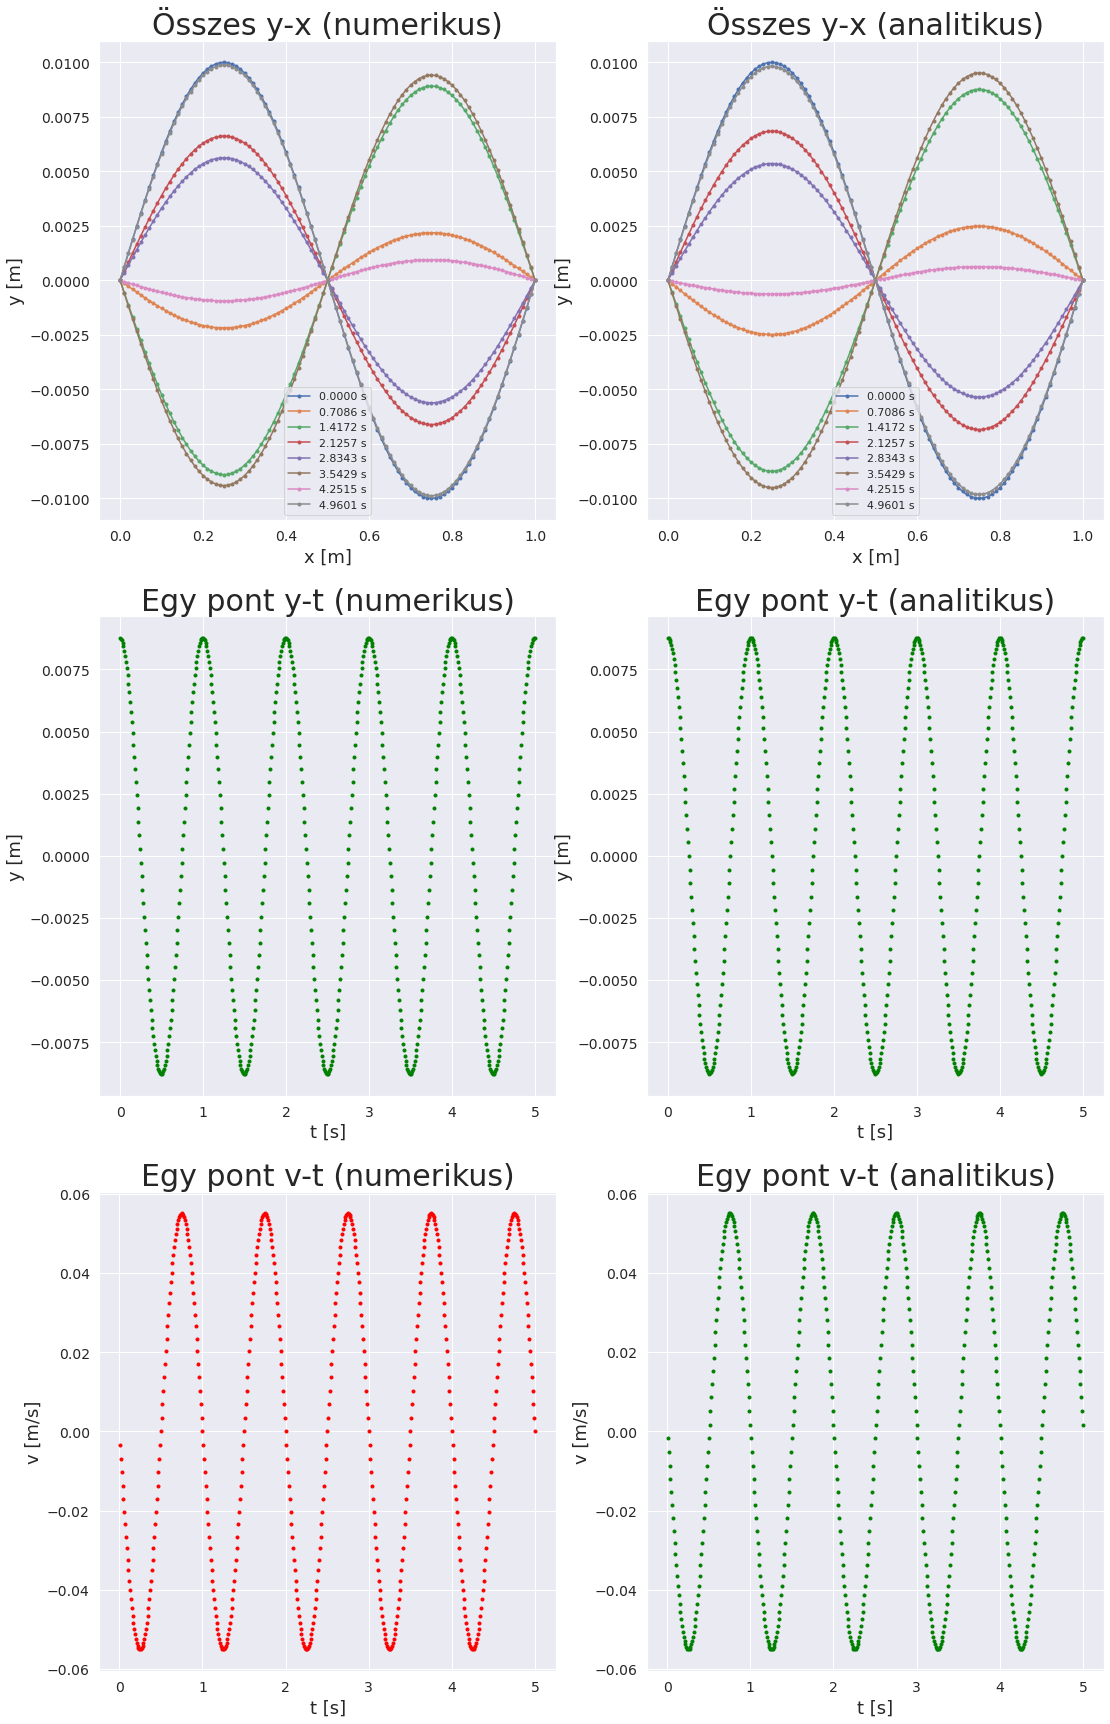

In [217]:
fig, ax = plt.subplots(3,2,figsize=(18,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
y_anal_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    yia = anal_mode1(i*dt,n00)
    ax[1][0].plot(i*dt,yi[N_x//3],'o',markersize=ms,color="green")
    ax[1][1].plot(i*dt,yia[N_x//3],'o',markersize=ms,color="green")
    if yi_ is not None:
        ax[2][0].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=ms,color="red")
        ax[2][1].plot(i*dt,(yia[N_x//3]-y_anal_)/dt,'o',markersize=ms,color="green")
    yi_ = yi[N_x//3]
    y_anal_ = yia[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0][0].plot(x,yi,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
        ax[0][1].plot(x,yia,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0][0].legend()
ax[0][0].set_xlabel("x [m]",fontsize=xy_s)
ax[0][0].set_ylabel("y [m]",fontsize=xy_s)
ax[0][0].set_title("Összes y-x (numerikus)",fontsize=t_s)
ax[1][0].set_xlabel("t [s]",fontsize=xy_s)
ax[1][0].set_ylabel("y [m]",fontsize=xy_s)
ax[1][0].set_title("Egy pont y-t (numerikus)",fontsize=t_s)
ax[2][0].set_xlabel("t [s]",fontsize=xy_s)
ax[2][0].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][0].set_title("Egy pont v-t (numerikus)",fontsize=t_s)
ax[0][1].legend()
ax[0][1].set_xlabel("x [m]",fontsize=xy_s)
ax[0][1].set_ylabel("y [m]",fontsize=xy_s)
ax[0][1].set_title("Összes y-x (analitikus)",fontsize=t_s)
ax[1][1].set_xlabel("t [s]",fontsize=xy_s)
ax[1][1].set_ylabel("y [m]",fontsize=xy_s)
ax[1][1].set_title("Egy pont y-t (analitikus)",fontsize=t_s)
ax[2][1].set_xlabel("t [s]",fontsize=xy_s)
ax[2][1].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][1].set_title("Egy pont v-t (analitikus)",fontsize=t_s)

print("idáig eljut")

plt.savefig("imgs/f2/mode1_3.jpg")

print("c = %4.4f m/s, c' = %4.4f m/s" %(c,c_))

A folyamat állapota 0.0 %.
A folyamat állapota 5.0 %.
A folyamat állapota 10.0 %.
A folyamat állapota 15.0 %.
A folyamat állapota 20.0 %.
A folyamat állapota 25.0 %.
A folyamat állapota 30.0 %.
A folyamat állapota 35.0 %.
A folyamat állapota 40.0 %.
A folyamat állapota 45.0 %.
A folyamat állapota 50.0 %.
A folyamat állapota 55.00000000000001 %.
A folyamat állapota 60.0 %.
A folyamat állapota 65.0 %.
A folyamat állapota 70.0 %.
A folyamat állapota 75.0 %.
A folyamat állapota 80.0 %.
A folyamat állapota 85.0 %.
A folyamat állapota 90.0 %.
A folyamat állapota 95.0 %.
A folyamat állapota 100.0 %.


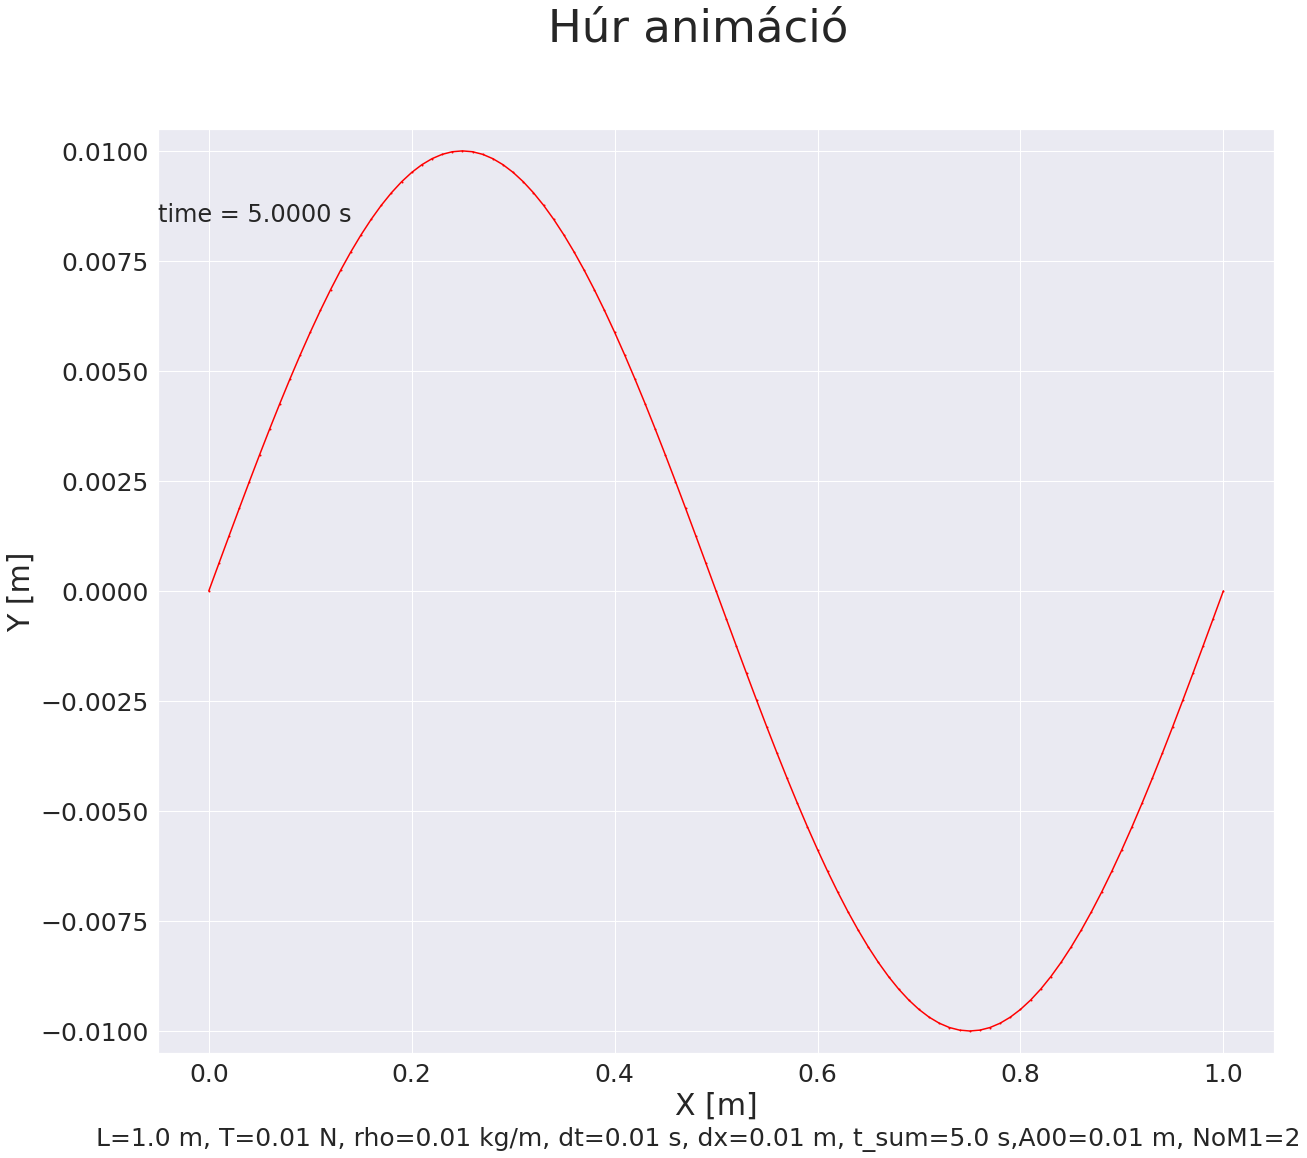

In [177]:
# ANIMÁCIÓ ELKÉSZÍTÉSE

save_ani = "./imgs/f2/animation_imgs"

hur_animation_imgs(save,save_ani)
save_video(save_ani,"./animations/animation_f2",speed=40)

## 4 (c>c')

In [115]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.02
dx = 0.01
t_sum = 5
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.02', '0.01', '5.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'mode1', './data/f2/mode1.data'], returncode=0)

Az if elágazásban lép ki.
20
c = 1.0000 m/s, c' = 0.4472 m/s


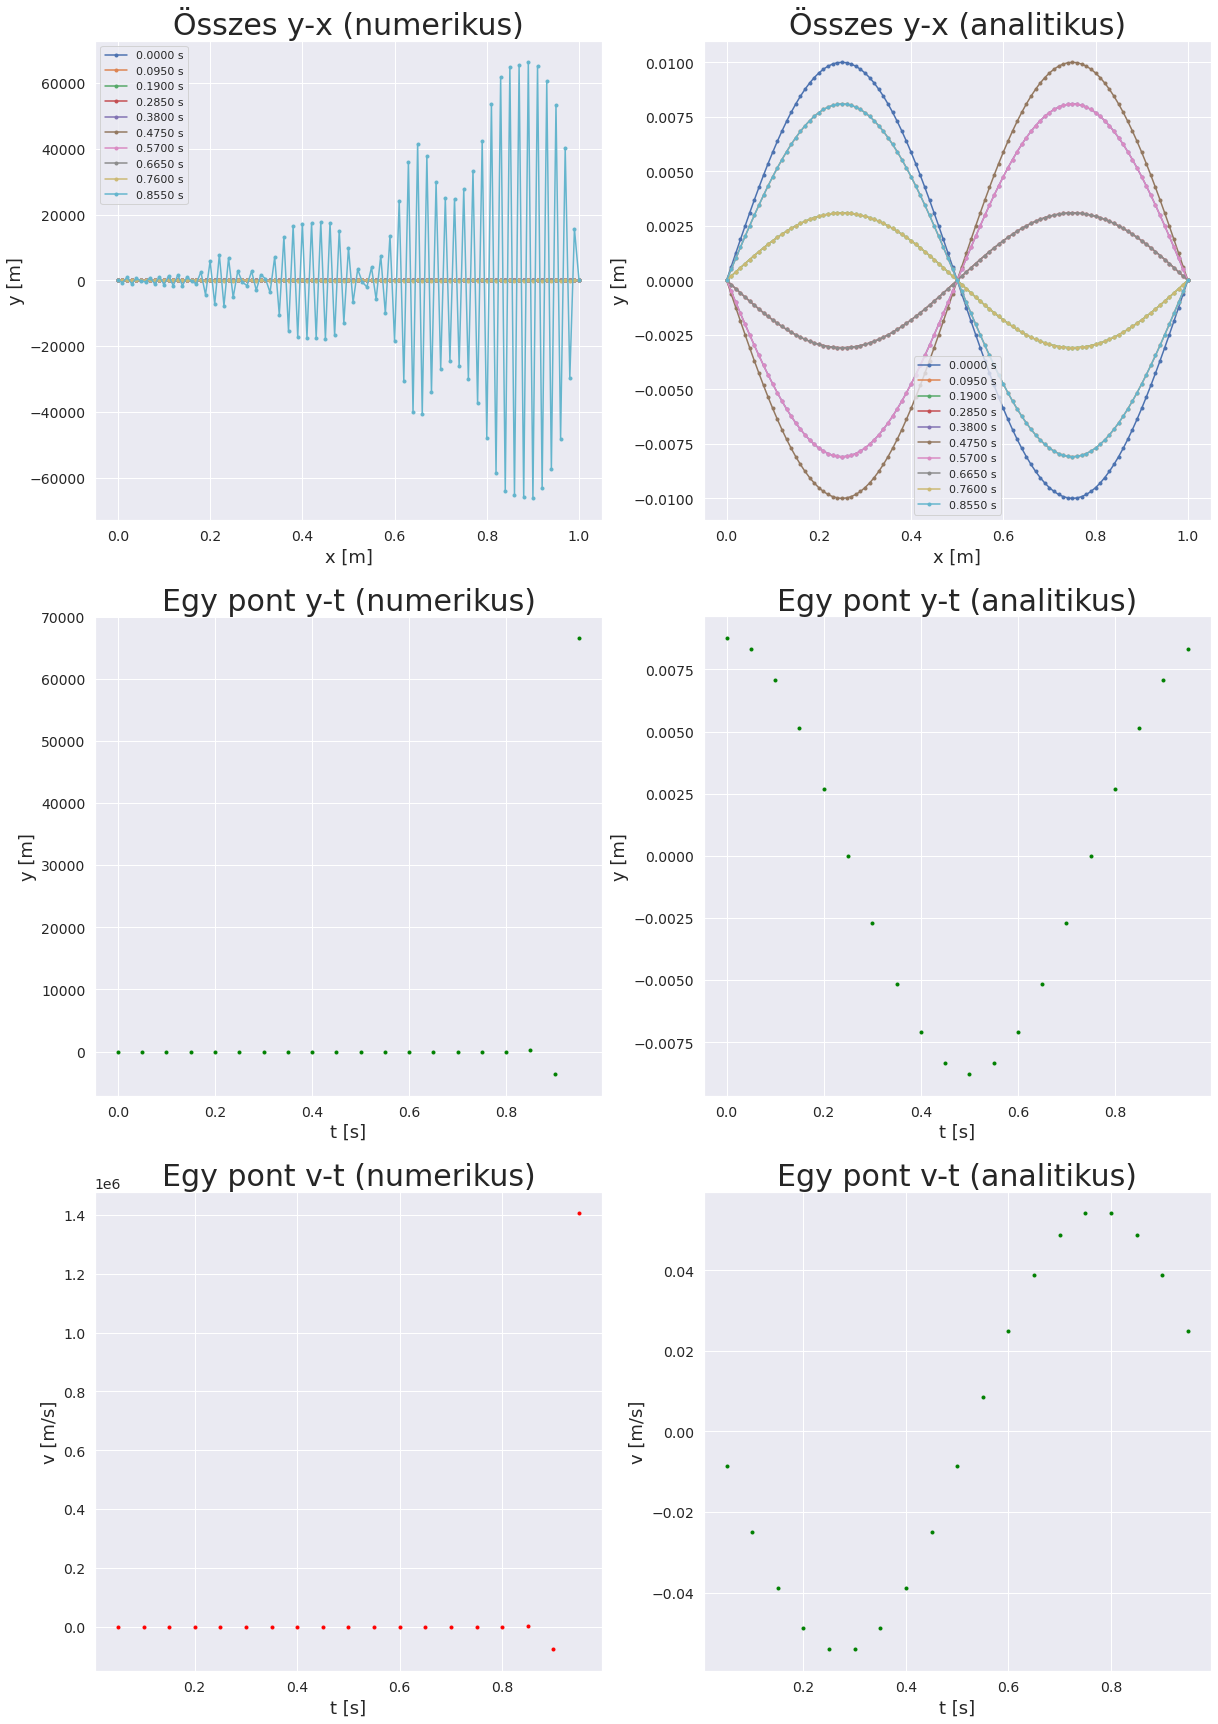

In [121]:
f = open(save,"r")
szamlal = 0
for i in range(N_t):
    try:
        yi_string = f.readline()
        yi = np.array(yi_string.strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        print(yi_string)
        szamlal = i
        break
    
    if max(abs(yi)) >= 1000000:
        print("Az if elágazásban lép ki.")
        szamlal = i + 1
        break
N_t = szamlal
f.close()

print(N_t)

t_sum = (N_t - 1.0) * dt
caption = create_caption()

fig, ax = plt.subplots(3,2,figsize=(20,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
y_anal_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    yia = anal_mode1(i*dt,n00)
    ax[1][0].plot(i*dt,yi[N_x//3],'o',markersize=ms,color="green")
    ax[1][1].plot(i*dt,yia[N_x//3],'o',markersize=ms,color="green")
    if yi_ is not None:
        ax[2][0].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=ms,color="red")
        ax[2][1].plot(i*dt,(yia[N_x//3]-y_anal_)/dt,'o',markersize=ms,color="green")
    yi_ = yi[N_x//3]
    y_anal_ = yia[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0][0].plot(x,yi,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
        ax[0][1].plot(x,yia,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0][0].legend()
ax[0][0].set_xlabel("x [m]",fontsize=xy_s)
ax[0][0].set_ylabel("y [m]",fontsize=xy_s)
ax[0][0].set_title("Összes y-x (numerikus)",fontsize=t_s)
ax[1][0].set_xlabel("t [s]",fontsize=xy_s)
ax[1][0].set_ylabel("y [m]",fontsize=xy_s)
ax[1][0].set_title("Egy pont y-t (numerikus)",fontsize=t_s)
ax[2][0].set_xlabel("t [s]",fontsize=xy_s)
ax[2][0].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][0].set_title("Egy pont v-t (numerikus)",fontsize=t_s)
ax[0][1].legend()
ax[0][1].set_xlabel("x [m]",fontsize=xy_s)
ax[0][1].set_ylabel("y [m]",fontsize=xy_s)
ax[0][1].set_title("Összes y-x (analitikus)",fontsize=t_s)
ax[1][1].set_xlabel("t [s]",fontsize=xy_s)
ax[1][1].set_ylabel("y [m]",fontsize=xy_s)
ax[1][1].set_title("Egy pont y-t (analitikus)",fontsize=t_s)
ax[2][1].set_xlabel("t [s]",fontsize=xy_s)
ax[2][1].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][1].set_title("Egy pont v-t (analitikus)",fontsize=t_s)

plt.savefig("imgs/f2/mode1_4.jpg")

print("c = %4.4f m/s, c' = %4.4f m/s" %(c,c_))

## 5 (c>c')

In [122]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.1
dx = 0.01
t_sum = 5
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.1', '0.01', '5.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'mode1', './data/f2/mode1.data'], returncode=0)

Az elágazásban lép ki.
17
c = 1.0000 m/s, c' = 0.3162 m/s


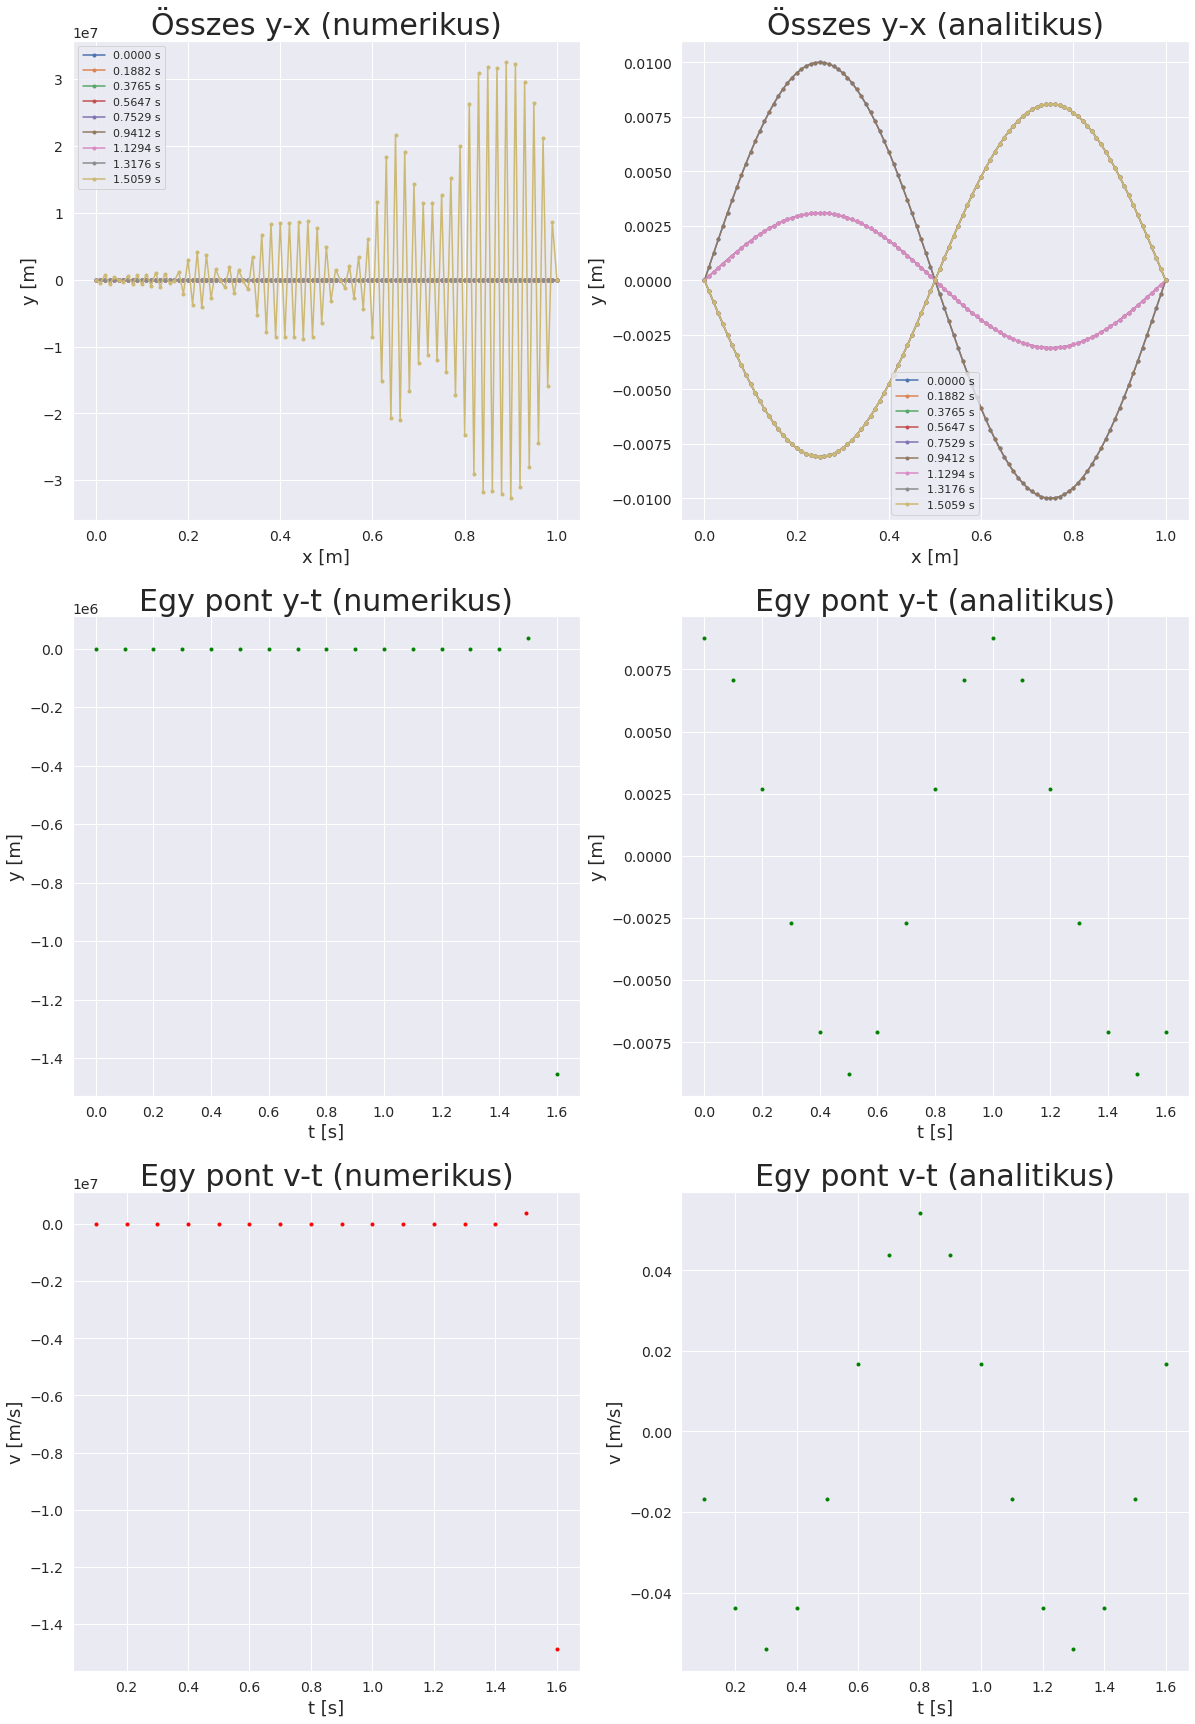

In [123]:
f = open(save,"r")
szamlal = 0
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        print(i)
        szamlal = i + 1
        break
    
    if max(abs(yi)) >= 1000000:
        print("Az elágazásban lép ki.")
        szamlal = i + 1
        break
N_t = szamlal
f.close()

print(N_t)

t_sum = (N_t - 1.0) * dt
caption = create_caption()

fig, ax = plt.subplots(3,2,figsize=(20,30))
#fig.suptitle("Első feladat", fontsize=st_s)

f = open(save,"r")

x = np.linspace(0,L,N_x)
yi = None
yi_ = None
y_anal_ = None
for i in range(N_t):
    try:
        yi = np.array(f.readline().strip().split('\t'),dtype=float)
    except:
        print("End of File.")
        break
    yia = anal_mode1(i*dt,n00)
    ax[1][0].plot(i*dt,yi[N_x//3],'o',markersize=ms,color="green")
    ax[1][1].plot(i*dt,yia[N_x//3],'o',markersize=ms,color="green")
    if yi_ is not None:
        ax[2][0].plot(i*dt,(yi[N_x//3]-yi_)/dt,'o',markersize=ms,color="red")
        ax[2][1].plot(i*dt,(yia[N_x//3]-y_anal_)/dt,'o',markersize=ms,color="green")
    yi_ = yi[N_x//3]
    y_anal_ = yia[N_x//3]
    if i % (N_t // 7) == 0:
        ax[0][0].plot(x,yi,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
        ax[0][1].plot(x,yia,'-o',markersize=ms,label="%2.4f s" %(i/N_t*t_sum))
f.close()
ax[0][0].legend()
ax[0][0].set_xlabel("x [m]",fontsize=xy_s)
ax[0][0].set_ylabel("y [m]",fontsize=xy_s)
ax[0][0].set_title("Összes y-x (numerikus)",fontsize=t_s)
ax[1][0].set_xlabel("t [s]",fontsize=xy_s)
ax[1][0].set_ylabel("y [m]",fontsize=xy_s)
ax[1][0].set_title("Egy pont y-t (numerikus)",fontsize=t_s)
ax[2][0].set_xlabel("t [s]",fontsize=xy_s)
ax[2][0].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][0].set_title("Egy pont v-t (numerikus)",fontsize=t_s)
ax[0][1].legend()
ax[0][1].set_xlabel("x [m]",fontsize=xy_s)
ax[0][1].set_ylabel("y [m]",fontsize=xy_s)
ax[0][1].set_title("Összes y-x (analitikus)",fontsize=t_s)
ax[1][1].set_xlabel("t [s]",fontsize=xy_s)
ax[1][1].set_ylabel("y [m]",fontsize=xy_s)
ax[1][1].set_title("Egy pont y-t (analitikus)",fontsize=t_s)
ax[2][1].set_xlabel("t [s]",fontsize=xy_s)
ax[2][1].set_ylabel("v [m/s]",fontsize=xy_s)
ax[2][1].set_title("Egy pont v-t (analitikus)",fontsize=t_s)

plt.savefig("imgs/f2/mode1_5.jpg")

print("c = %4.4f m/s, c' = %4.4f m/s" %(c,c_))

## Mikor száll el

Állapot: 1000 / 1000


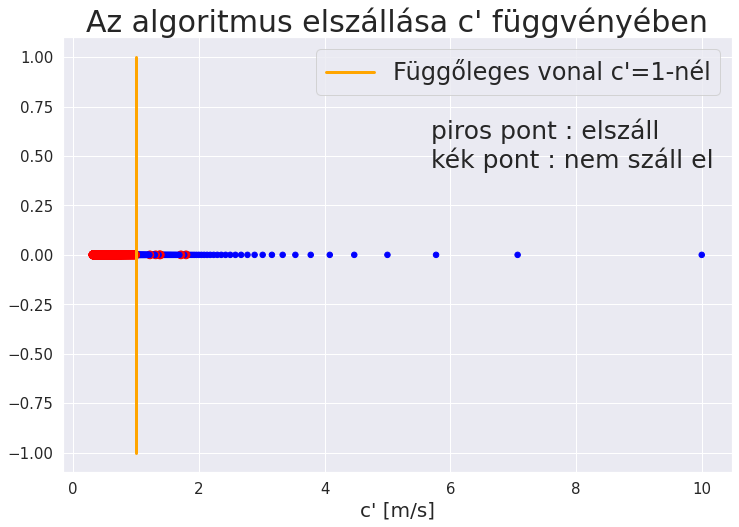

In [176]:
style = {'xtick.labelsize' : 15, 'ytick.labelsize' : 15}
plt.style.use(style)
tick_s = 25 #xtick ytick size
st_s = 30 #suptitle size
t_s = 30 #axis title size
xy_s = 15 #xy axis label size
hs = 1 #hspace
ws = 1 #wspace

# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"


src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dx = 0.01
A00 = 0.4
n00 = 2
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
L = (N_x - 1.0) * dx
c = (T/rho)**0.5

dts = np.linspace(0.0001,0.1,1000)
c_s = (dx/dts)**0.5

elszall = []

for i in range(len(dts)):

    dt = dts[i]
    t_sum = 5
    x00 = 0.4
    x01 = 0.7
    y00 = 0.01
    y01 = 0.005
    A00 = 0.4
    A01 = y01
    n00 = 2
    n01 = 3
    mode = "mode1"
    save = "./data/f2/mode1.data"

    N_t = int(t_sum / dt + 1)
    t_sum = (N_t - 1.0) * dt
    c_ = (dx/dt)**0.5

    subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])
    
    f = open(save,"r")
    b = True # ha elszáll, akkor ez False lesz és nem appendel 0-val
    yj = None
    for j in range(N_t):
        try:
            yj = np.array(f.readline().strip().split('\t'),dtype=float)
        except:
            elszall.append(1)
            b = False
            break

        if max(abs(yj)) >= 100 * A00:
            elszall.append(1)
            b = False
            break
    f.close()
    if b:
        elszall.append(0)
    
    clear_output()
    print(f"Állapot: {i+1} / {1000}")
    
colors = []
markersize = []
for i in range(len(dts)):
    if elszall[i]:
        colors.append("red")
        markersize.append(60)
    else:
        colors.append("blue")
        markersize.append(30)

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(c_s,np.zeros(len(c_s)),s=markersize,c=colors)
ax.plot([1,1],[-1,1],"-",lw=3,color="orange",label="Függőleges vonal c'=1-nél")
ax.text(0.55, 0.7, "piros pont : elszáll\nkék pont : nem száll el", transform=ax.transAxes,fontsize=25)
ax.legend(fontsize=24)
ax.set_xlabel("c' [m/s]",fontsize=20)
ax.set_title("Az algoritmus elszállása c' függvényében",fontsize=t_s)


plt.savefig("imgs/f2/elszall.jpg")

# Feladat 3

**A megoldás alapján becsüld meg a hullám sebességét.**

Ugyan a szimulációhoz szükséges paraméter a hullám sebessége, itt megpróbálok kifejleszteni egy módszert, amivel az adatok kiszámolt adatsor alapján is meg tudjuk határozni a hullám aktuális sebességét.

Egy lehetséges módszer a hullám sebességének mérésére a hullámcsúcsok mozgásának vizsgálat. Meg kell keresni a hullám egyik maximumát és annak az x pozícióját követni. Én ehhez a húr elején elindítottam egy dirac delta szerű hullámot, és végig követtem ezt a legelső hullámot, amíg el nem érte a húr végét. Ehhez készítettem egy x-t grafikont, melynek meredeksége megadja a húr terjedési sebességét.

In [132]:
def find_maxes(arr):
    maxes = []
    for i in range(1,len(arr)-1):
        if arr[i] > arr[i-1] and arr[i] > arr[i+1]:
            maxes.append(i)
    return maxes

def linfunc(x,a,b):
    return a * x + b

style = {'xtick.labelsize' : 15, 'ytick.labelsize' : 15}
plt.style.use(style)
tick_s = 25 #xtick ytick size
st_s = 30 #suptitle size
t_s = 30 #axis title size
xy_s = 15 #xy axis label size
hs = 1 #hspace
ws = 1 #wspace

0
t=817,maxes=817

1
t=259,maxes=259

2
t=80,maxes=80

3
t=80,maxes=80

4
t=61,maxes=61



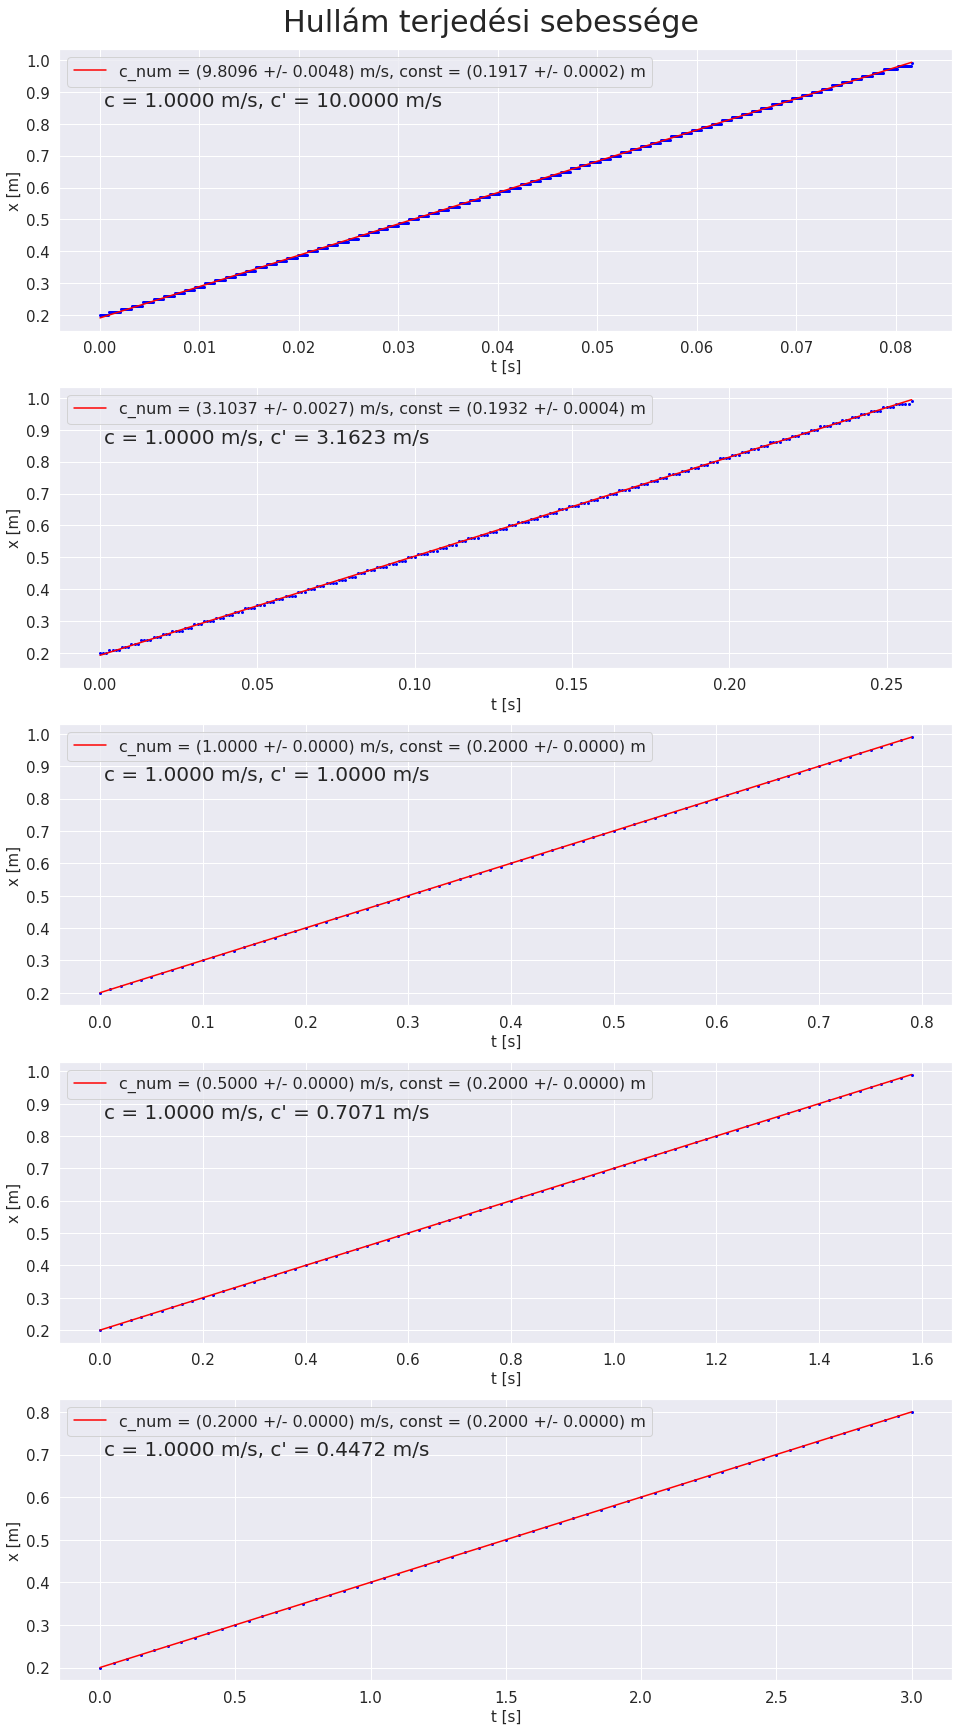

In [140]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.0001
dx = 0.01
t_sum = 3
x00 = 0.2
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "dirac"
save = "./data/f3/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

fig, ax = plt.subplots(5,1,figsize=(16,30))
fig.suptitle("Hullám terjedési sebessége", fontsize=st_s, y=0.9)
x = np.linspace(0,(N_x-1)*dx,N_x)
dts = [0.0001,0.001,0.01,0.02,0.05]
for i in range(5):
    dt = dts[i]
    N_t = int(t_sum / dt + 1)
    c_ = (dx/dt)**0.5
    subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])
    
    f = open(save,"r")
    
    yj = None
    t = []
    maxes = []
    for j in range(N_t):
        try:
            yj = np.array(f.readline().strip().split('\t'),dtype=float)
        except:
            print("End of File.")
            break
        try:
            maxes.append(x[find_maxes(yj)[-1]])
        except:
            print("Elszállt az algoritmus.")
        t.append(j*dt)
        if (maxes[-1] >= x[-2]):
            break
    f.close()

    print(i)
    t = np.array(t)
    maxes = np.array(maxes)
    print(f"t={len(t)},maxes={len(maxes)}\n")

    ax[i].plot(t,maxes,'o',markersize=2,color="blue")

    popt, pcov = curve_fit(linfunc,t,maxes)
    perr = np.sqrt(np.diag(pcov))

    ax[i].plot(t,linfunc(t,*popt),'-',color="red",
            label="c_num = (%4.4f +/- %4.4f) m/s, const = (%4.4f +/- %4.4f) m" %(popt[0],perr[0],popt[1],perr[1]))
    ax[i].text(0.05, 0.8, "c = %4.4f m/s, c' = %4.4f m/s" %(c,c_), transform=ax[i].transAxes,fontsize=20)
    
    ax[i].legend(fontsize=16)

    ax[i].set_xlabel("t [s]",fontsize=xy_s)
    ax[i].set_ylabel("x [m]",fontsize=xy_s)
    #ax[i].set_title("Hullám terjedési sebessége",fontsize=t_s)

plt.savefig("imgs/f3/c.jpg")

Állapot: 1000 / 1000


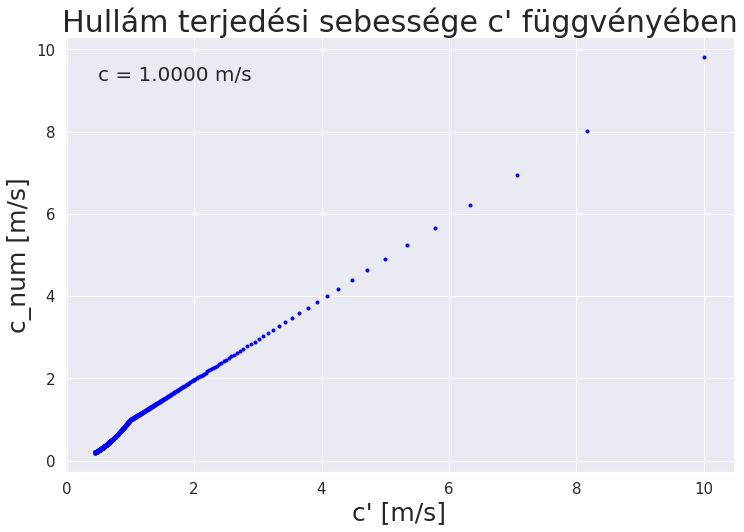

In [146]:
dts = np.linspace(0.0001,0.05,1000)
c_s = (dx/dts)**0.5
c_nums = []

for i in range(len(dts)):
    dt = dts[i]
    N_t = int(t_sum / dt + 1)
    subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])
    
    f = open(save,"r")
    
    yj = None
    t = []
    maxes = []
    for j in range(N_t):
        try:
            yj = np.array(f.readline().strip().split('\t'),dtype=float)
        except:
            print("End of File.")
            break
        try:
            maxes.append(x[find_maxes(yj)[-1]])
        except:
            print("Elszállt az algoritmus.")
        t.append(j*dt)
        if (maxes[-1] >= x[-2]):
            break
    f.close()

    t = np.array(t)
    maxes = np.array(maxes)

    popt, pcov= curve_fit(linfunc,t,maxes)
    c_nums.append(popt[0])
    clear_output()
    print(f"Állapot: {i+1} / {len(dts)}")
    
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(c_s,c_nums,'.',color="blue")
ax.text(0.05, 0.9, "c = %4.4f m/s" %(c), transform=ax.transAxes,fontsize=20)
ax.set_xlabel("c' [m/s]",fontsize=25)
ax.set_ylabel("c_num [m/s]",fontsize=25)
ax.set_title("Hullám terjedési sebessége c' függvényében",fontsize=t_s)
    
plt.savefig("imgs/f3/c2.jpg")

In [157]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.01
dx = 0.01
t_sum = 5
x00 = 0.2
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "dirac"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.01', '0.01', '5.0', '0.2', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'dirac', './data/f2/mode1.data'], returncode=0)

A folyamat állapota 0.0 %.
A folyamat állapota 5.0 %.
A folyamat állapota 10.0 %.
A folyamat állapota 15.0 %.
A folyamat állapota 20.0 %.
A folyamat állapota 25.0 %.
A folyamat állapota 30.0 %.
A folyamat állapota 35.0 %.
A folyamat állapota 40.0 %.
A folyamat állapota 45.0 %.
A folyamat állapota 50.0 %.
A folyamat állapota 55.00000000000001 %.
A folyamat állapota 60.0 %.
A folyamat állapota 65.0 %.
A folyamat állapota 70.0 %.
A folyamat állapota 75.0 %.
A folyamat állapota 80.0 %.
A folyamat állapota 85.0 %.
A folyamat állapota 90.0 %.
A folyamat állapota 95.0 %.
A folyamat állapota 100.0 %.
A képek elkészültek.


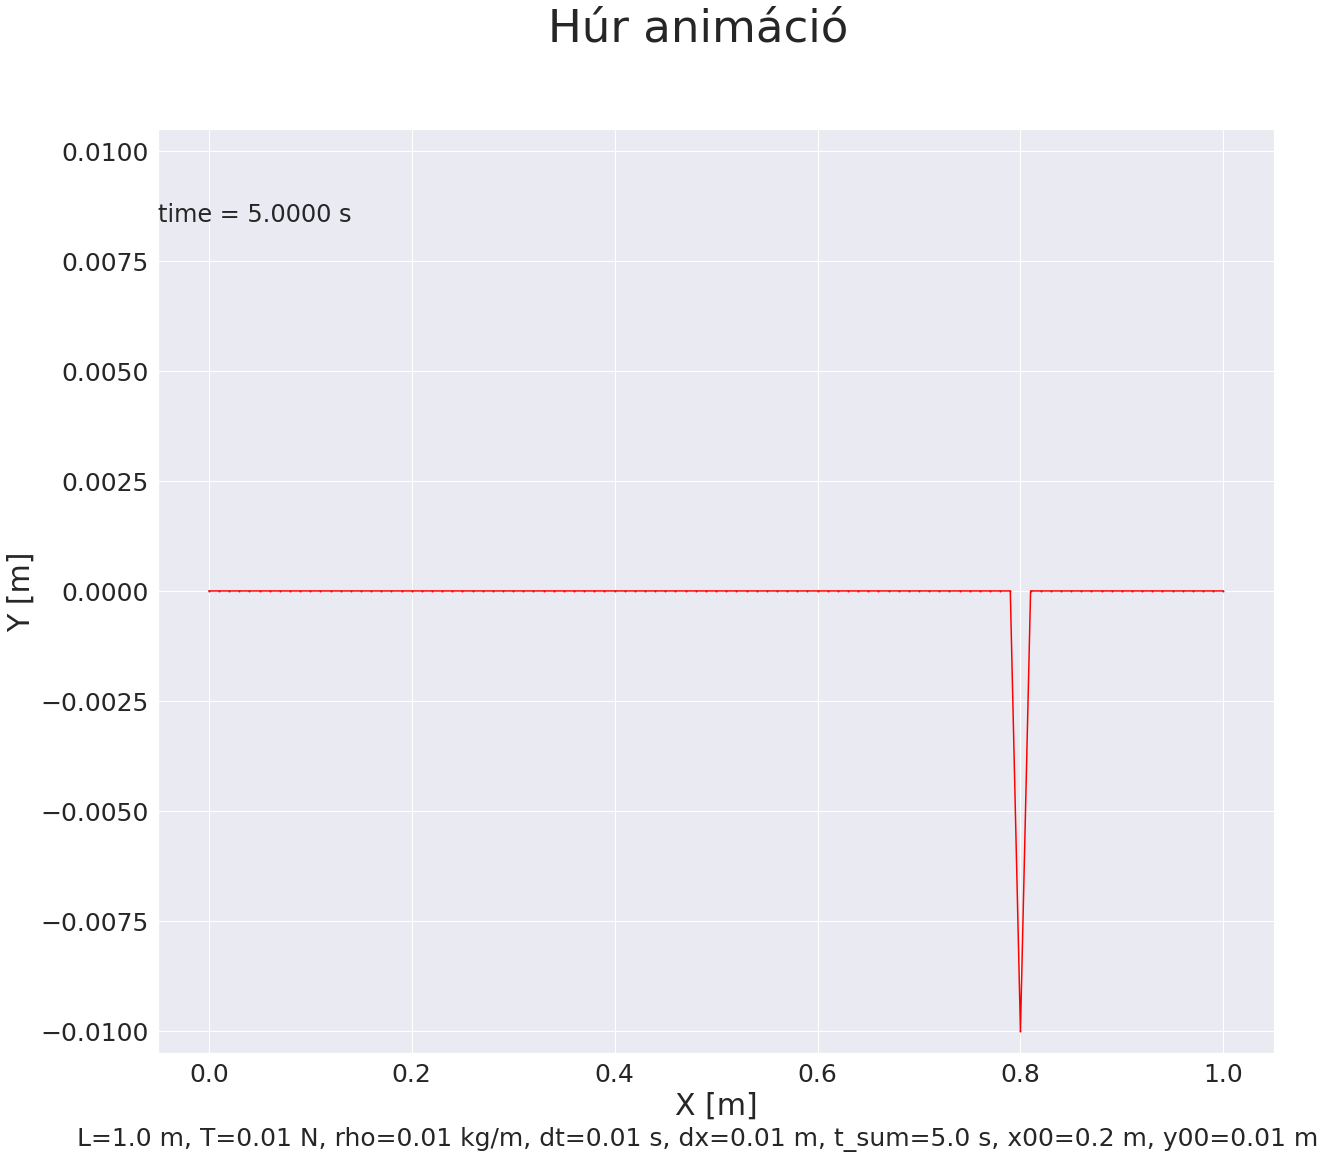

In [158]:
# ANIMÁCIÓ ELKÉSZÍTÉSE

save_ani = "./imgs/f3/animation_imgs"

hur_animation_imgs(save,save_ani)
print("A képek elkészültek.")
save_video(save_ani,"./animations/animation_f3",speed=50)

# Feladat 5

**Linearitás vizsgálata.<br>
a) Két kezdőfeltétel futtatása, és kombinált kezdőfeltétel futtatás.<br>
b) Két közeli normálmódus keverékének vizsgálata.**

In [197]:
# params: L T rho dt dx t_sum x00 x01 y00 y01 A00 A01 n00 n01 mode save
# modes: "triang" "triangCombine" "dirac" "mode1" "mode2"

src = "./hur.bin"
L = 1
T = 0.01
rho = 0.01
dt = 0.01
dx = 0.01
t_sum = 5
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
A00 = y00
A01 = y01
n00 = 2
n01 = 3
mode = "mode1"
save = "./data/f2/mode1.data"

N_x = int(L / dx + 1)
N_t = int(t_sum / dt + 1)
t_sum = (N_t - 1.0) * dt
L = (N_x - 1.0) * dx
c = (T/rho)**0.5
c_ = (dx/dt)**0.5

caption = create_caption()

#subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

In [198]:
save = "./data/f5/triang_1.data"
mode = "triang"
subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.01', '0.01', '5.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'triang', './data/f5/triang_1.data'], returncode=0)

In [199]:
save = "./data/f5/triang_2.data"
mode = "triang"
x00 = x01
y00 =y01
subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.01', '0.01', '5.0', '0.7', '0.7', '0.005', '0.005', '0.01', '0.005', '2', '3', 'triang', './data/f5/triang_2.data'], returncode=0)

In [200]:
save = "./data/f5/triangCombine.data"
mode = "triangCombine"
x00 = 0.4
x01 = 0.7
y00 = 0.01
y01 = 0.005
subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])
caption_triang = create_caption()

In [201]:
save = "./data/f5/mode1_1.data"
mode = "mode1"
subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.01', '0.01', '5.0', '0.4', '0.7', '0.01', '0.005', '0.01', '0.005', '2', '3', 'mode1', './data/f5/mode1_1.data'], returncode=0)

In [202]:
save = "./data/f5/mode1_2.data"
mode = "mode1"
A00 = A01
n00 = n01
subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])

CompletedProcess(args=['./hur.bin', '1.0', '0.01', '0.01', '0.01', '0.01', '5.0', '0.4', '0.7', '0.01', '0.005', '0.005', '0.005', '3', '3', 'mode1', './data/f5/mode1_2.data'], returncode=0)

In [203]:
save = "./data/f5/mode2.data"
mode = "mode2"
A00 = y00
A01 = y01
n00 = 2
n01 = 3
subprocess.run([src,f"{L}",f"{T}",f"{rho}",f"{dt}",f"{dx}",f"{t_sum}",f"{x00}",f"{x01}",f"{y00}",f"{y01}",f"{A00}",f"{A01}",f"{n00}",f"{n01}",f"{mode}",f"{save}"])
caption_modes = create_caption()

A folyamat állapota 0.0 %.
A folyamat állapota 5.0 %.
A folyamat állapota 10.0 %.
A folyamat állapota 15.0 %.
A folyamat állapota 20.0 %.
A folyamat állapota 25.0 %.
A folyamat állapota 30.0 %.
A folyamat állapota 35.0 %.
A folyamat állapota 40.0 %.
A folyamat állapota 45.0 %.
A folyamat állapota 50.0 %.
A folyamat állapota 55.00000000000001 %.
A folyamat állapota 60.0 %.
A folyamat állapota 65.0 %.
A folyamat állapota 70.0 %.
A folyamat állapota 75.0 %.
A folyamat állapota 80.0 %.
A folyamat állapota 85.0 %.
A folyamat állapota 90.0 %.
A folyamat állapota 95.0 %.
A folyamat állapota 100.0 %.
A képek elkészültek.


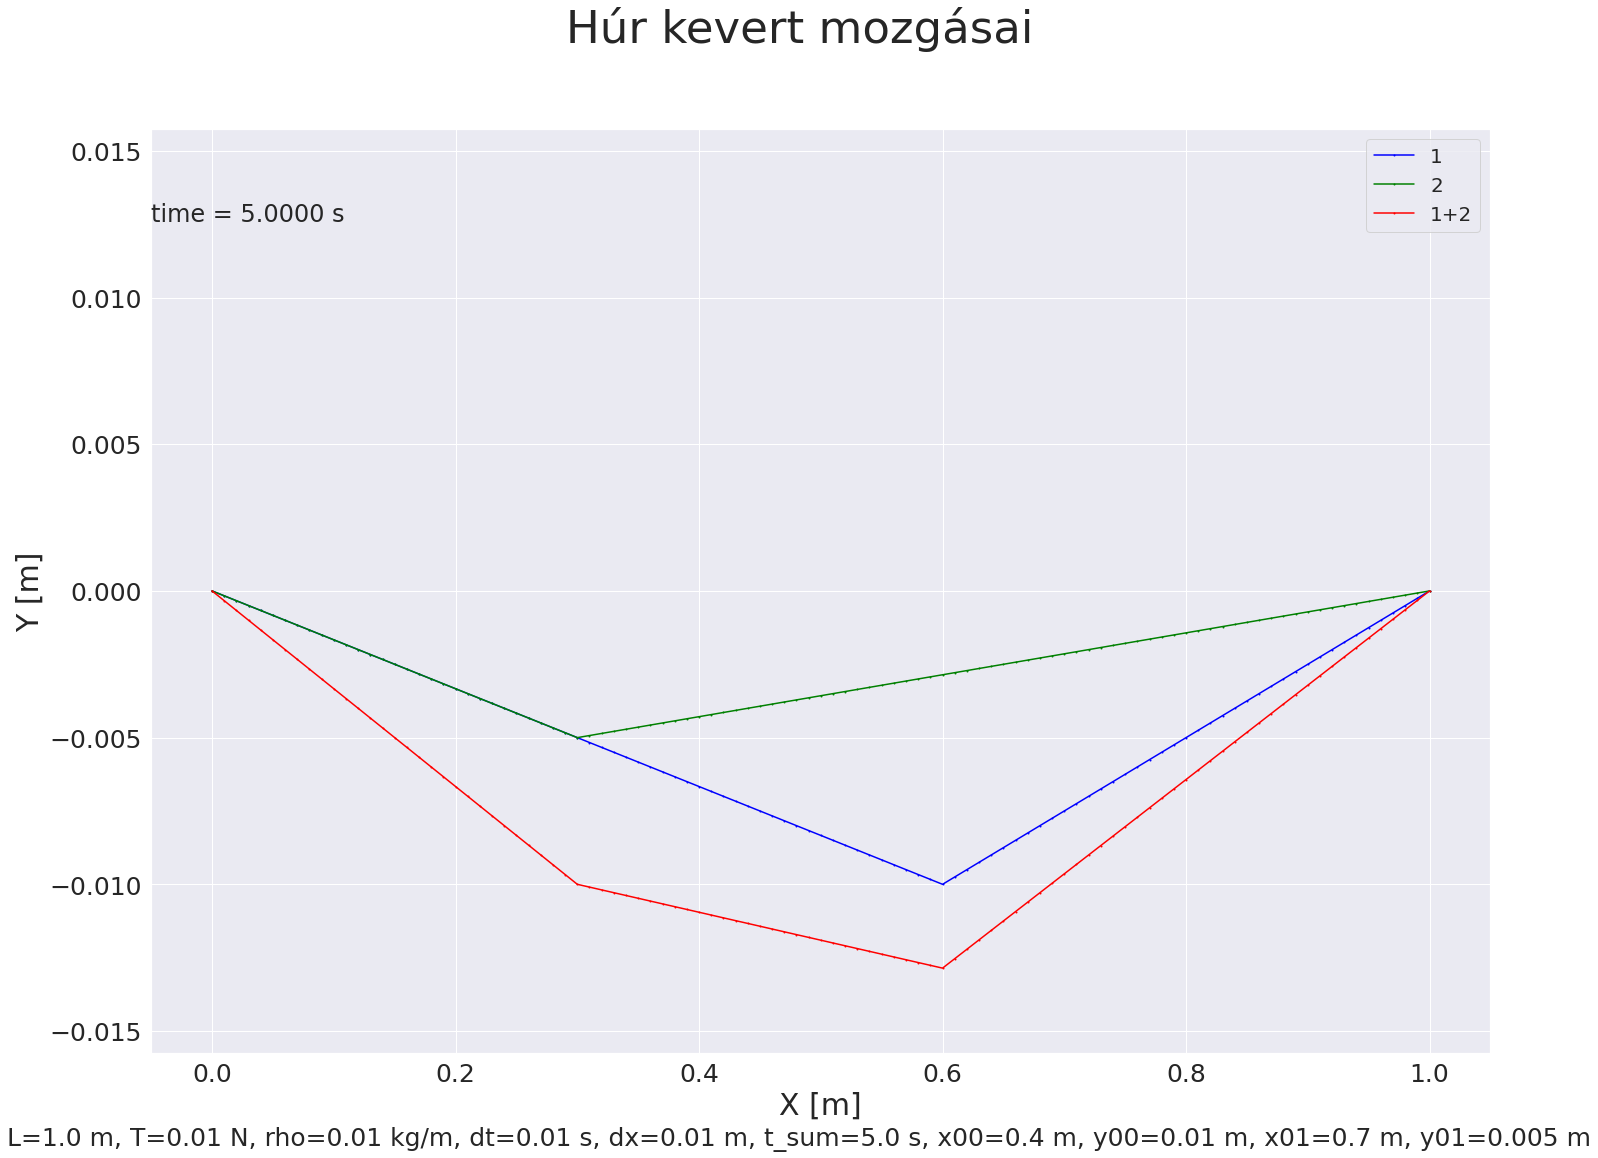

In [212]:
# ANIMÁCIÓ ELKÉSZÍTÉSE

save_ani = "./imgs/f5/animation_imgs_triang"

hur_animation_imgs_mixed("./data/f5/triang_1.data","./data/f5/triang_2.data","./data/f5/triangCombine.data",
                         save_ani,caption_triang)
print("A képek elkészültek.")
save_video(save_ani,"./animations/animation_f5_triang",speed=50)

A folyamat állapota 0.0 %.
A folyamat állapota 5.0 %.
A folyamat állapota 10.0 %.
A folyamat állapota 15.0 %.
A folyamat állapota 20.0 %.
A folyamat állapota 25.0 %.
A folyamat állapota 30.0 %.
A folyamat állapota 35.0 %.
A folyamat állapota 40.0 %.
A folyamat állapota 45.0 %.
A folyamat állapota 50.0 %.
A folyamat állapota 55.00000000000001 %.
A folyamat állapota 60.0 %.
A folyamat állapota 65.0 %.
A folyamat állapota 70.0 %.
A folyamat állapota 75.0 %.
A folyamat állapota 80.0 %.
A folyamat állapota 85.0 %.
A folyamat állapota 90.0 %.
A folyamat állapota 95.0 %.
A folyamat állapota 100.0 %.
A képek elkészültek.


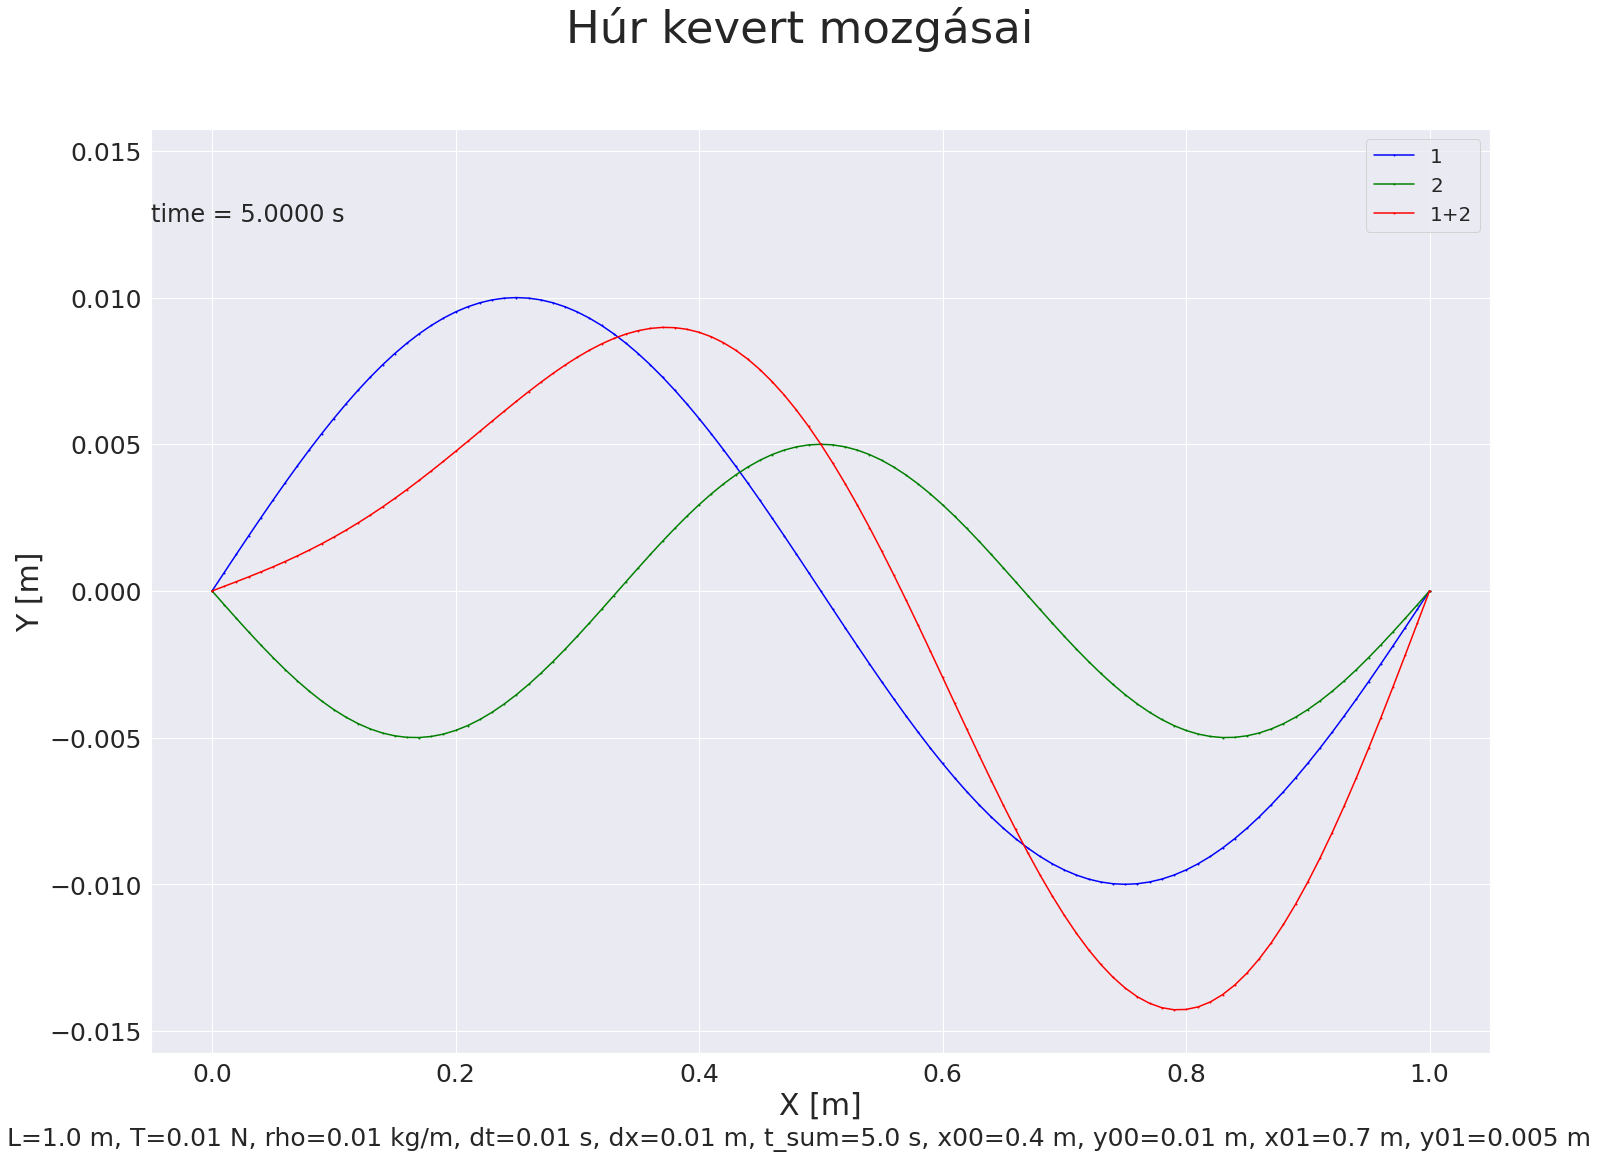

In [213]:
# ANIMÁCIÓ ELKÉSZÍTÉSE

save_ani = "./imgs/f5/animation_imgs_modes"

hur_animation_imgs_mixed("./data/f5/mode1_1.data","./data/f5/mode1_2.data","./data/f5/mode2.data",
                         save_ani,caption_triang)
print("A képek elkészültek.")
save_video(save_ani,"./animations/animation_f5_modes",speed=50)

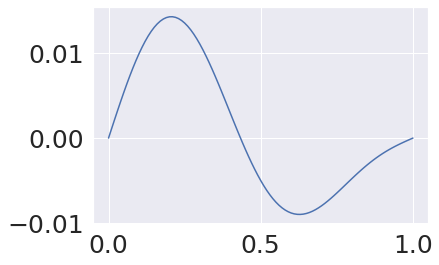

In [185]:
def mode2(x):
    return A00 * np.sin((np.pi*n00)/L*x) + A01 * np.sin((np.pi*n01)/L*x);

x_arr = np.linspace(0,L,N_x)
y_arr = mode2(x)
plt.plot(x_arr,y_arr)

In [211]:
def hur_animation_imgs_mixed(file1,file2,file3,save_ani,caption):
    """Elkészíti az animáció képeit a file-ban található adatokból és elmenti a save_ani helyen."""
    
    #x adatpontok és t időpillanatok megadása
    x = np.linspace(0,L,N_x)
    t = np.linspace(0,t_sum,N_t)

    #Ábra határok
    yMaxAbs = y00 + y01
    xmin = -0.05 * L
    xmax = 1.05 * L
    ymin = -1.05 * yMaxAbs
    ymax = 1.05 * yMaxAbs

    #style megadása
    dic = {"xtick.labelsize" : tick_s, "ytick.labelsize" : tick_s}
    plt.style.use(dic)

    #ábra inicializálása
    fig = plt.figure(figsize=(24,17))
    fig.suptitle("Húr kevert mozgásai",fontsize=45)
    fig.text(0.5, 0.05, caption, ha='center', fontsize=25)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax.set_xlabel("X [m]",fontsize=30)
    ax.set_ylabel("Y [m]",fontsize=30)
    ax.grid(b=True)

    hurfig1, = ax.plot([], [], 'o-', markersize=1, color="blue", label="1")
    hurfig2, = ax.plot([], [], 'o-', markersize=1, color="green", label="2")
    hurfig3, = ax.plot([], [], 'o-', markersize=1, color="red", label="1+2")
    time_template = 'time = %.4f s'
    time_text = ax.text(0.0, 0.9, '', transform=ax.transAxes,fontsize=24)
    ax.legend(fontsize=20)

    #file beolvasás és képek elkészítése
    f1 = open(file1,"r")
    f2 = open(file2,"r")
    f3 = open(file3,"r")
    yi1 = None
    yi2 = None
    yi3 = None

    for i in range(N_t):
        try:
            yi1 = np.array(f1.readline().strip().split('\t'),dtype=float)
            yi2 = np.array(f2.readline().strip().split('\t'),dtype=float)
            yi3 = np.array(f3.readline().strip().split('\t'),dtype=float)
        except:
            print("End of File.")
            break

        hurfig1.set_data(x,yi1)
        hurfig2.set_data(x,yi2)
        hurfig3.set_data(x,yi3)

        time_text.set_text(time_template % (t[i]))
        plt.savefig(f"{save_ani}/%4.4d.jpg"% (i))

        if i % (N_t // 20) == 0:
            szazalek = t[i] / t_sum * 100
            print(f"A folyamat állapota {szazalek} %.")

    f1.close()
    f2.close()
    f3.close()